In [1]:
import os
import pydicom as dcm
from tools import *
from pydicom.uid import generate_uid
from datetime import datetime
import cv2
import matplotlib.pyplot as plt
import json
import csv

In [2]:
PATH = '/mnt/iDriveShare/Kayla/CBCT_images/kayla_extracted/' # Image Path
anon_RS_path = '/mnt/iDriveShare/Kayla/CBCT_images/anonymized/limbus_RS/' # RS files of defaced CTs
og_RS_path = '/mnt/iDriveShare/Kayla/CBCT_images/anonymized/limbus_RS_OG/' # RS files of original CTs

In [3]:
patient_list = ['19', '35', '54', '59', '81', '118', '272', '274', '437', '447', '448', '454', '459', '462', '469', '473', '474', '478', '483', '517', '518', '600', '625', '628', '633', '644', '651', '662', '673', '685', '694', '721', '723', '734', '738', '755', '770', '773', '786', '790', '820', '833', '838', '848', '892', '910', '937', '945', '946', '961', '965', '973', '1167', '1255', '1288', '1314', '1502', '1511', '1552', '1888', '1892', '1949', '1987', '2017', '2027', '2037', '2041', '2056', '2058', '2061']
print(len(patient_list), "patients.")

70 patients.


# OAR Auto-Segementation

In [4]:
# Change UID of dicom so it can be uploaded back to TPS

In [5]:
def change_uids(CT_path, output_file_path):
    new_series_instance_uid = generate_uid()
    new_study_instance_uid = generate_uid()
    
    for f in [f for f in os.listdir(CT_path) if 'CT' in f]:
        # Load the DICOM file
        dicom_data = dcm.dcmread(os.path.join(CT_path,f))

        
        
        # Generate new UIDs
        new_sop_instance_uid = generate_uid()
       
        # Replace UIDs
        dicom_data.SOPInstanceUID = new_sop_instance_uid
        dicom_data.SeriesInstanceUID = new_series_instance_uid
        dicom_data.StudyInstanceUID = new_study_instance_uid

        dicom_data.PatientID = 'non_anon_test_id'
        dicom_data.PatientName = CT_path.split('/')[-2]
        
        # Save the updated DICOM file
        dicom_data.save_as(output_file_path+'CT.'+new_sop_instance_uid+'.dcm')


In [6]:
output_path = '/data/kayla/anon_images/new_uid_cts/'

In [7]:
patients_to_change = ['19', '35', '54', '59', '81', '118', '272', '274', '437', '447', '448', '454', '459', '462', '469', '473', '474', '478', '483', '517', '518', '600', '625', '628', '633', '644', '651', '662', '673', '685', '694', '721', '723', '734', '738', '755', '770', '773', '786', '790', '820', '833', '838', '848', '892', '910', '937', '945', '946', '961', '965', '973', '1167', '1255', '1288', '1314', '1502', '1511', '1552', '1888', '1892', '1949', '1987', '2017', '2027', '2037', '2041', '2056', '2058', '2061']
patients_same_date = ['517','518','118','478','673','838']
# patients_to_change = ['790','437','448','19','274','848','1288','600','625','1552']
done = patients_to_change # Change to [] if redoing

In [1068]:
for p in [p for p in patients_to_change if p not in done]:
    print(p)
    CT_path = os.path.join(PATH,p,get_first_CT(os.path.join(PATH,p)))
    # print(CT_path.split('/')[-2])
    change_uids(os.path.join(CT_path),output_path)
    done.append(p)


In [1074]:
# Create the dict of files pointing to:
# - CT_1: the original CT scan
# - RS_1: the auto-segmented RS file of the original CT scan
# - RS_A: the auto-segmented RS file of the defaced CT scan

In [8]:
dict_p = {}
dict_dates = {}
file_dict = {}
dict_uids = {}
for p in patient_list:
    CT_name = get_first_CT(os.path.join(PATH,p))
    CT_path = os.path.join(PATH,p,CT_name)
    CT_file = [f for f in os.listdir(CT_path) if 'CT' in f][0]
    
    UID = dcm.read_file(PATH+p+'/'+CT_name+'/'+CT_file).FrameOfReferenceUID
    dict_uids[UID] = p
    
    dict_p[p] = CT_name
    file_dict[p] = {}
    file_dict[p]['CT']=os.path.join(CT_path,CT_file)
    date = datetime.strptime(CT_name[12:], "%d_%b_%Y").strftime("%Y%m%d")
    
    if date in dict_dates:
        print("PROBLEM - SAME DATE")
        print(dict_dates[date], p)
    dict_dates[date] = p


PROBLEM - SAME DATE
118 478
PROBLEM - SAME DATE
517 518
PROBLEM - SAME DATE
673 838


In [9]:
len(dict_uids)

70

In [10]:
# Since patients were mapped to images with dates (just my own dict system), fix those with the same date

In [11]:
duplicate_dates = ['20191220','20211005','20190410']

In [12]:
#manually swap CT date for 1511, as took CT2 for anon
dict_p['1511'] = '20231002_CT_29_SEP_2023'
dict_dates['20230929'] = '1511'
dict_uids['1.2.246.352.221.461671203788179538416824606995535925934'] = '1511'
del dict_uids['1.2.246.352.221.52147478103674962812757250728644617873']

In [13]:

p_done =[]
for f in sorted([x for x in os.listdir(anon_RS_path) if 'RS' in x[0:2]]):# or 'limbus' in x[0:6]]):
    # print(f)
    # date = dcm.read_file(anon_RS_path+f).StudyDate
    # print(
   
    uid = dcm.read_file(anon_RS_path+f).FrameOfReferenceUID
    try:
        # print(f,date)
        # patient = dict_dates[date]
        patient = dict_uids[uid]
        if patient in p_done:
            print(patient, f)
            print(patient,file_dict[patient]['RS_A'])
        p_done.append(patient)
        file_dict[patient]['RS_A']=anon_RS_path+f
        # if date in duplicate_dates:
        #     print("anon",date,f)
    except Exception as e: 
        print("Error with RS",f,e)
        
    
    # print(date, dict_dates[str(date)])

for f in [x for x in os.listdir(og_RS_path) if 'RS' in x[0:2]]:#or 'limbus' in x[0:6]]:
    try:
        # print(p)
        # date = dcm.read_file(og_RS_path+f).StudyDate
        uid = dcm.read_file(og_RS_path+f).FrameOfReferenceUID
        # print(f,date)
        # patient = dict_dates[date]
        patient = dict_uids[uid]
        
        file_dict[patient]['RS_1']=og_RS_path+f
        # if date in duplicate_dates:
        #     print("og",date,f)    
    except Exception as e: 
        print("Error with OG",f,e)
            



Error with RS RS.1.2.826.0.1.3680043.8.498.10968679513518758955888124713111828897.dcm '1.2.246.352.221.55545278117470276949863706741079864465'
Error with RS RS.1.2.826.0.1.3680043.8.498.11543568290575043242173131748169888042.dcm '1.2.246.352.221.55545278117470276949863706741079864465'
Error with RS RS.1.2.826.0.1.3680043.8.498.18100706660915904812293193087294243279.dcm '1.2.246.352.221.47927005596030484265125225420560628392'
Error with RS RS.1.2.826.0.1.3680043.8.498.50225248025328293750190627338594216481.dcm '1.2.246.352.221.47927005596030484265125225420560628392'
Error with OG RS.1.2.826.0.1.3680043.8.498.96185752954431579966705789460282490567.dcm '1.2.246.352.221.47927005596030484265125225420560628392'
Error with OG RS.1.2.826.0.1.3680043.8.498.84255825403150160387184760556926745694.dcm '1.2.246.352.221.52147478103674962812757250728644617873'
Error with OG RS.1.2.826.0.1.3680043.8.498.48710965246676524075188275743971083814.dcm '1.2.246.352.221.55545278117470276949863706741079864465'

In [12]:
file_dict['755']

{'CT': '/mnt/iDriveShare/Kayla/CBCT_images/kayla_extracted/755/20170217_CT_16_JAN_2017/CT.1.2.246.352.221.56518085876875079907494319526174120620.dcm',
 'RS_A': '/mnt/iDriveShare/Kayla/CBCT_images/anonymized/limbus_RS/RS.1.2.246.352.205.5497165284361287269.336238748074122654.dcm',
 'RS_1': '/mnt/iDriveShare/Kayla/CBCT_images/anonymized/limbus_RS_OG/RS.1.2.826.0.1.3680043.8.498.50991965776574594073972939044943935841.dcm'}

In [13]:
dcm.read_file(file_dict['59']['RS_A'])

KeyError: 'RS_A'

In [14]:
file_dict['600']['RS_A'] = '/mnt/iDriveShare/Kayla/CBCT_images/anonymized/limbus_RS/RS.1.2.826.0.1.3680043.8.498.10968679513518758955888124713111828897.dcm'
file_dict['59']['RS_A'] = '/mnt/iDriveShare/Kayla/CBCT_images/anonymized/limbus_RS/RS.1.2.826.0.1.3680043.8.498.18100706660915904812293193087294243279.dcm'

In [34]:
file_dict['517']['CT'] = '/mnt/iDriveShare/Kayla/CBCT_images/kayla_extracted/19/20180411_CT_09_APR_2018/CT.1.2.246.352.221.46157814662918147304165220025912152967.dcm'
# file_dict['517']['RS_A'] = '/mnt/iDriveShare/Kayla/CBCT_images/anonymized/limbus_RS/.dcm'
# file_dict['517']['RS_1'] = '/mnt/iDriveShare/Kayla/CBCT_images/anonymized/limbus_RS_OG/.dcm'

In [1105]:
# dcm.read_file(anon_RS_path+'RS.1.2.826.0.1.3680043.8.498.50225248025328293750190627338594216481.dcm')

In [1106]:
# dcm.read_file(og_RS_path+'RS.1.2.826.0.1.3680043.8.498.85841875200979640019685194166979601816.dcm')

In [1129]:
file_dict['1511']

{'CT': '/mnt/iDriveShare/Kayla/CBCT_images/kayla_extracted/1511/20230911_CT_30_AUG_2023/CT.1.2.246.352.221.50117404257811694446353653326544018071.dcm',
 'RS_A': '/mnt/iDriveShare/Kayla/CBCT_images/anonymized/limbus_RS/RS.1.2.826.0.1.3680043.8.498.52770828518262227483841189377756826083.dcm',
 'RS_1': '/mnt/iDriveShare/Kayla/CBCT_images/anonymized/limbus_RS_OG/RS.1.2.826.0.1.3680043.8.498.84255825403150160387184760556926745694.dcm'}

In [1108]:
# dcm.read_file(og_RS_path+f)

In [1337]:
# dict_uids

In [1110]:
len(dict_uids)

70

In [16]:

def calculate_dice_score_3d(volume1, volume2):
    assert volume1.shape == volume2.shape, "Volumes must have the same shape"

    intersection = np.logical_and(volume1, volume2).sum()
    union = volume1.sum() + volume2.sum()

    dice_score = 2 * intersection / union

    return dice_score


In [17]:
# def xyz_to_image_coords(X,Y,Z,spacing,origin):
#     X_new, Y_new, Z_new = [], [], []
#     for x,y,z in zip(X,Y,Z):
#         X_new.append((x-origin[0])/spacing[0])
#         Y_new.append((y-origin[1])/spacing[1])
#         Z_new.append((z-origin[2])/spacing[2])
    
#     return X_new, Y_new, Z_new

In [18]:
def xyz_to_image_coords_3D(contour,spacing,origin):
    
    image_coords = []
    for slice in contour:
        new_line = []
        for i in range(0,len(slice),3):
            new_line.append((slice[i]-origin[0])/spacing[0])
            new_line.append((slice[i+1]-origin[1])/spacing[1])
            new_line.append((slice[i+2]-origin[2])/spacing[2])
#             print(slice[i+2],origin[2],spacing[2],'=',(slice[i+2]-origin[2])/spacing[2])
        
#         x_indices, y_indices, z_indices = slice[0::3], slice[1::3], slice[2::3]
#         x,y,z = xyz_to_image_coords_contour(x_indices,y_indices,z_indices,spacing,origin)
        image_coords.append(new_line)
        
    return image_coords
        

In [19]:
# def convert_contours_to_volume(contours):
#     """
#     Convert a list of 2D contours to a 3D binary volume.

#     Args:
#         contours (list of np.ndarray): List of binary masks (contours).

#     Returns:
#         np.ndarray: 3D binary volume.
#     """
#     # Determine the dimensions of the 3D volume
#     num_slices, height, width = len(contours), contours[0].shape[0], contours[0].shape[1]

#     # Initialize an empty 3D volume
#     volume = np.zeros((num_slices, height, width), dtype=np.uint8)

#     # Stack the 2D contours to create the 3D volume
#     for i, contour in enumerate(contours):
#         volume[i, :, :] = contour

#     return volume


In [20]:
def get_binary_volume(img_coords, max_z=0,rows=512, cols=512):
    if max_z == 0:
        max_z = max(int(s[2]) for s in img_coords)
        
    volume_shape = (max_z + 1, rows, cols)
    volume_binary = np.zeros(volume_shape, dtype=np.uint8)




    for c_slice in img_coords:
        z = int(c_slice[2])
#         print(z)
        X, Y = c_slice[::3], c_slice[1::3]

        cont_xy = np.array([tuple([int(x),int(y)]) for x,y in zip(X,Y)])
        cont_xy = cont_xy.reshape((-1,1,2))


        for i in range(0,len(volume_binary[0])):
            for j in range(0,len(volume_binary[0][0])):
                result = cv2.pointPolygonTest(cont_xy, (i,j), False) 
                if result == 1:
                    volume_binary[z][j][i] = 1





    return volume_binary




In [21]:
def get_DSC_single(contour_truth, contour_test,spacing,origin):
    height = max(len(contour_truth), len(contour_test))
    # print("height:",height)
#     start_z = min(contour_truth[0][2], contour_test[0][2])
#     z_spacing = contour_truth[0][2]-contour_truth[1][2]
    # print(contour_truth[0][2])
    start_z = min(contour_truth[0][2], contour_test[0][2])

    img_coords_truth = xyz_to_image_coords_3D(contour_truth,spacing,[origin[0],origin[1],start_z])
    img_coords_test = xyz_to_image_coords_3D(contour_test,spacing,[origin[0],origin[1],start_z])
    
    max_z = max(max(int(s[2]) for s in img_coords_truth),max(int(s[2]) for s in img_coords_test))
    # print("max z:",max_z)
    # 
    binary_truth = get_binary_volume(img_coords_truth,max_z)
    binary_test = get_binary_volume(img_coords_test,max_z)
    
    score = calculate_dice_score_3d(binary_truth, binary_test)
    
    return score

In [22]:
def get_DSC_all(RS_truth, RS_test,CT_dcm,ignore_first_slice=False):
    # ignore body
   
    names_truth = [n for n in find_ROI_names(RS_truth) if n!= 'BODY']
    names_test = [n for n in find_ROI_names(RS_test) if n!= 'BODY']
    
 
    name_truth_not_done = names_truth.copy()
    scores = {}
    print(names_truth,names_test)


    
    cont_truth,zs_truth = get_all_ROI_contours(names_truth,RS_truth)
    cont_test,zs_test = get_all_ROI_contours(names_test,RS_test)
    # print(cont_truth)

    if ignore_first_slice:
        min_z = 999999
        new_cont = []
        for name in names_truth:
            # print("02",cont_test[name][0][2])
            if cont_truth[name][0][2] < min_z:
                min_z = cont_truth[name][0][2] 
            if name in cont_test:
                if cont_test[name][0][2] < min_z:
                    min_z = cont_test[name][0][2] 
        for name in names_truth:
            new_cont = []
            for c in cont_truth[name]:
                if c[2] != min_z:
                    new_cont.append(c)
                else:
                    print("TRUTH removing",name,c)
            # print( cont_test[name][0] )
            cont_truth[name] = new_cont
            
        for name in names_test:
            new_cont = []
            for c in cont_test[name]:
                if c[2] != min_z:
                    new_cont.append(c)
                else:
                    print("TEST removing",name,c)
            # print( cont_test[name][0] )
            cont_test[name] = new_cont
        
    origin = CT_dcm.ImagePositionPatient
    spacing = [CT_dcm.PixelSpacing[0],CT_dcm.PixelSpacing[1],CT_dcm.SliceThickness]
    # print(origin,spacing)
    
    for name in names_test:
        if name not in names_truth:
            print("WARNING: NO GROUND TRUTH FOR CONTOUR NAMED", name)
            continue
        
        # print(name)
            # 
        try:
            # if name == 'NECK
            score = get_DSC_single(cont_truth[name],cont_test[name],spacing,origin)
        
            scores[name] = score
            name_truth_not_done.remove(name)
        except Exception as e:
            print(name,"ERROR",e)
    print("Names in truth not matched:", name_truth_not_done)
    
    return scores


In [23]:
p = '1552'
test_rs_a = dcm.read_file(file_dict[p]['RS_A'])
test_rs_og = dcm.read_file(file_dict[p]['RS_1'])
test_ct = dcm.read_file(file_dict[p]['CT'])

In [1119]:
# get_DSC_all(test_rs_og, test_rs_a, test_ct)

In [612]:
dict_DSC = {}



In [24]:
# Check that all patietns have all files
for p in patient_list:
    p = str(p)
    try:
        file_dict[p]['RS_A']
    except:
        print(p,"NO RS_A")

    try:
        file_dict[p]['RS_1']
    except:
        print(p,"NO RS_1")

    try:
        file_dict[p]['CT']
    except:
        print(p,"NO CT")

1511 NO RS_1


In [650]:
# for p in ['633']:
#     # print(p)
#     # try:
#         RS_A = dcm.read_file(file_dict[p]['RS_A'])
#         RS_1 = dcm.read_file(file_dict[p]['RS_1'])
#         CT = dcm.read_file(file_dict[p]['CT'])
    
#         dict_DSC[p] = get_DSC_all(RS_1, RS_A, CT)
#     # except Exception as e:
    #     print(e)

In [652]:
with open('/data/kayla/deface_file_dict.json', "w") as outfile:
    json.dump(file_dict,outfile)

In [653]:
with open('/data/kayla/deface_file_dict.json', "r") as outfile:
    file_dict = json.load(outfile)

In [1396]:
##### p = '118'
for p in ['633','965']:#patients_to_change:#['462']:#,'965']:
    print(p)
    RS_A = dcm.read_file(file_dict[p]['RS_A'])
    RS_1 = dcm.read_file(file_dict[p]['RS_1'])
    CT = dcm.read_file(file_dict[p]['CT'])
    ignore_first_slice = False
    if p =='633' or p=='965':
        ignore_first_slice = True
    dict_DSC2[p] = get_DSC_all(RS_1, RS_A, CT,ignore_first_slice)

633
['SpinalCord~', 'SpinalCanal', 'Pituitary', 'Pharynx', 'Parotid_R', 'Parotid_L', 'OpticNrv_R', 'OpticNrv_L', 'OpticChiasm', 'Lung_R', 'Lung_L', 'LN_Neck_VI', 'LN_Neck_V_R', 'LN_Neck_V_L', 'LN_Neck_R', 'LN_Neck_L', 'LN_Neck_IB_R', 'LN_Neck_IB_L', 'LN_Neck_IA', 'LN_Neck_2347AB_R', 'LN_Neck_2347AB_L', 'Lips', 'Lens_R', 'Lens_L', 'Larynx', 'Hippocampus_R', 'Hippocampus_L', 'Glnd_Thyroid', 'Glnd_Submand_R', 'Glnd_Submand_L', 'Eye_R', 'Eye_L', 'Esophagus', 'Cornea_R', 'Cornea_L', 'Cochlea_R', 'Cochlea_L', 'Clavicle_R', 'Clavicle_L', 'Cavity_Oral', 'Brainstem', 'Brain', 'BrachialPlex_R', 'BrachialPlex_L', 'Bone_Mandible', 'Bone_Hyoid'] ['Bone_Hyoid', 'Bone_Mandible', 'BrachialPlex_L', 'BrachialPlex_R', 'Brain', 'Brainstem', 'Cavity_Oral', 'Clavicle_L', 'Clavicle_R', 'Cochlea_L', 'Cochlea_R', 'Cornea_L', 'Cornea_R', 'Esophagus', 'Eye_L', 'Eye_R', 'Glnd_Submand_L', 'Glnd_Submand_R', 'Glnd_Thyroid', 'Hippocampus_L', 'Hippocampus_R', 'Larynx', 'Lips', 'LN_Neck_2347AB_L', 'LN_Neck_2347AB_R', '

/tmp/ipykernel_1986355/3834082200.py:7: RuntimeWarning: invalid value encountered in divide
  dice_score = 2 * intersection / union


Names in truth not matched: ['Lens_R', 'Lens_L']
965
['Bone_Hyoid', 'Bone_Mandible', 'BrachialPlex_L', 'BrachialPlex_R', 'Brain', 'Brainstem', 'Cavity_Oral', 'Clavicle_L', 'Clavicle_R', 'Cochlea_L', 'Cochlea_R', 'Cornea_L', 'Cornea_R', 'Esophagus', 'Eye_L', 'Eye_R', 'Glnd_Submand_L', 'Glnd_Submand_R', 'Glnd_Thyroid', 'Hippocampus_L', 'Hippocampus_R', 'Larynx', 'Lips', 'LN_Neck_2347AB_L', 'LN_Neck_2347AB_R', 'LN_Neck_IA', 'LN_Neck_IB_L', 'LN_Neck_IB_R', 'LN_Neck_L', 'LN_Neck_R', 'LN_Neck_V_L', 'LN_Neck_V_R', 'LN_Neck_VI', 'Lung_L', 'Lung_R', 'OpticChiasm', 'OpticNrv_L', 'OpticNrv_R', 'Parotid_L', 'Parotid_R', 'Pharynx', 'Pituitary', 'SpinalCanal', 'SpinalCord~'] ['SpinalCord~', 'SpinalCanal', 'LN_Neck_V_L', 'LN_Neck_R', 'LN_Neck_L', 'Pituitary', 'Pharynx', 'Parotid_R', 'Parotid_L', 'OpticNrv_R', 'OpticNrv_L', 'OpticChiasm', 'Lung_R', 'Lung_L', 'LN_Neck_VI', 'LN_Neck_V_R', 'Glnd_Submand_L', 'Eye_R', 'Eye_L', 'LN_Neck_IB_R', 'LN_Neck_IB_L', 'LN_Neck_IA', 'LN_Neck_2347AB_R', 'LN_Neck_2347A

In [25]:
for p in ['462','673','755','833','1511','1987']:
    file_dict[p]['RS_1'] = '/mnt/iDriveShare/Kayla/Defacing/CTs_for_limbus/limbus_1.8.1_'+p+'.dcm'
    file_dict[p]['RS_A'] = '/mnt/iDriveShare/Kayla/Defacing/CTs_for_limbus/limbus_1.8.1_'+p+'_A.dcm'
    p_path = '/mnt/iDriveShare/Kayla/Defacing/CTs_for_limbus/changeuid/'+p
    ct_path = os.path.join(p_path,os.listdir(p_path)[0])
    file_dict[p]['CT'] = os.path.join(ct_path,os.listdir(ct_path)[0])
    print(p,dcm.read_file(file_dict[p]['RS_1']).StudyDate)
    print(p,dcm.read_file(file_dict[p]['RS_A']).StudyDate)
    print(p,dcm.read_file(file_dict[p]['CT']).StudyDate)
    


462 20181012
462 20181012
462 20181012
673 20211124
673 20211124
673 20211124
755 20170220
755 20170220
755 20170220
833 20191003
833 20191003
833 20191003
1511 20230830
1511 20230830
1511 20230830
1987 20230616
1987 20230616
1987 20230616


In [ ]:
file_dict['462']['CT'] = '/mnt/iDriveShare/Kayla/Defacing/CTs_for_limbus/limbus_1.8.1_'+p+'.dcm'

In [ ]:
file_dict['973']['RS_1'] = 
file_dict['973']['RS_1'] = 
file_dict['973']['RS_1'] = 

file_dict['973']['RS_1'] = 
file_dict['973']['RS_1'] = 
file_dict['973']['RS_1'] = 

In [1345]:
file_dict['973']['RS_1'] = '/mnt/iDriveShare/Kayla/Defacing/CTs_for_limbus/limbus_1.8.1_973_1.dcm'

In [26]:
new_dsc = {}



In [28]:
ps_new = [f.split('_')[-2] for f in os.listdir('/mnt/iDriveShare/Kayla/Defacing/CTs_for_limbus/rerun_LNs/') if '_A.dcm' in f]
print(ps_new)

['1949', '454', '945', '723', '973', '946', '2027', '2058', '738', '469', '685', '1255', '473', '838', '54', '518', '694', '651', '820', '1892', '892', '937', '2061', '2017', '961', '773', '2041', '478', '1314', '81', '628', '474', '662', '734', '483', '35', '459', '721', '517', '2056', '1167', '1888', '910', '786', '965']


In [35]:
for p in sorted(ps_new):#,'462','833','755']:#,'965']:
    print(p)
    if p in new_dsc:
        print("already done")
        continue
    print(p)
    RS_1 = dcm.read_file('/mnt/iDriveShare/Kayla/Defacing/CTs_for_limbus/rerun_LNs/limbus_1.8.1_'+p+'.dcm')
    RS_A = dcm.read_file('/mnt/iDriveShare/Kayla/Defacing/CTs_for_limbus/rerun_LNs/limbus_1.8.1_'+p+'_A.dcm')
    CT = dcm.read_file(file_dict[p]['CT'])
    ignore_first_slice = False
    # if p =='633' or p=='965' or p=='755':
    #     ignore_first_slice = True
    new_dsc[p] = get_DSC_all(RS_1, RS_A, CT,ignore_first_slice)

1167
already done
1255
already done
1314
already done
1888
already done
1892
already done
1949
already done
2017
already done
2027
already done
2041
already done
2056
already done
2058
already done
2061
already done
35
already done
454
already done
459
already done
469
already done
473
already done
474
already done
478
already done
483
already done
517
517
['Bone_Hyoid', 'Bone_Mandible', 'BrachialPlex_L', 'BrachialPlex_R', 'Brain', 'Brainstem', 'Cavity_Oral', 'Clavicle_L', 'Clavicle_R', 'Cochlea_L', 'Cochlea_R', 'Cornea_L', 'Cornea_R', 'Esophagus', 'Eye_L', 'Eye_R', 'Glnd_Submand_L', 'Glnd_Submand_R', 'Glnd_Thyroid', 'Hippocampus_L', 'Hippocampus_R', 'Larynx', 'Lens_L', 'Lips', 'LN_Neck_2347AB_L', 'LN_Neck_2347AB_R', 'LN_Neck_IA', 'LN_Neck_IB_L', 'LN_Neck_IB_R', 'LN_Neck_L', 'LN_Neck_R', 'LN_Neck_V_L', 'LN_Neck_V_R', 'LN_Neck_VI', 'Lung_L', 'Lung_R', 'OpticChiasm', 'OpticNrv_L', 'OpticNrv_R', 'Parotid_L', 'Parotid_R', 'Pharynx', 'Pituitary', 'SpinalCanal', 'SpinalCord~'] ['Bone_Hyoid',

/tmp/ipykernel_1404815/3834082200.py:7: RuntimeWarning: invalid value encountered in divide
  dice_score = 2 * intersection / union


Names in truth not matched: ['Cornea_R']
685
685
['Bone_Hyoid', 'Bone_Mandible', 'BrachialPlex_L', 'BrachialPlex_R', 'Brain', 'Brainstem', 'Cavity_Oral', 'Clavicle_L', 'Clavicle_R', 'Cochlea_L', 'Cochlea_R', 'Cornea_L', 'Cornea_R', 'Esophagus', 'Eye_L', 'Eye_R', 'Glnd_Submand_L', 'Glnd_Submand_R', 'Glnd_Thyroid', 'Hippocampus_L', 'Hippocampus_R', 'Larynx', 'Lens_L', 'Lens_R', 'Lips', 'LN_Neck_2347AB_L', 'LN_Neck_2347AB_R', 'LN_Neck_IA', 'LN_Neck_IB_L', 'LN_Neck_IB_R', 'LN_Neck_L', 'LN_Neck_R', 'LN_Neck_V_L', 'LN_Neck_V_R', 'LN_Neck_VI', 'Lung_L', 'Lung_R', 'OpticChiasm', 'OpticNrv_L', 'OpticNrv_R', 'Parotid_L', 'Parotid_R', 'Pharynx', 'Pituitary', 'SpinalCanal', 'SpinalCord~'] ['Bone_Hyoid', 'Bone_Mandible', 'BrachialPlex_L', 'BrachialPlex_R', 'Brain', 'Brainstem', 'Cavity_Oral', 'Clavicle_L', 'Clavicle_R', 'Cochlea_L', 'Cochlea_R', 'Cornea_L', 'Cornea_R', 'Esophagus', 'Eye_L', 'Eye_R', 'Glnd_Submand_L', 'Glnd_Submand_R', 'Glnd_Thyroid', 'Hippocampus_L', 'Hippocampus_R', 'Larynx', 'Lip

In [ ]:
ps_new = [f.split('_')[-2] for f in os.listdir('/mnt/iDriveShare/Kayla/Defacing/CTs_for_limbus/rerun_LNs/') if '_A.dcm' in f]
for p in sorted(ps_new):#,'462','833','755']:#,'965']:
    print(p)
    if p in new_dsc:
        print("already done")
        continue
    print(p)
    RS_1 = dcm.read_file('/mnt/iDriveShare/Kayla/Defacing/CTs_for_limbus/rerun_LNs/limbus_1.8.1_'+p+'.dcm')
    RS_A = dcm.read_file('/mnt/iDriveShare/Kayla/Defacing/CTs_for_limbus/rerun_LNs/limbus_1.8.1_'+p+'_A.dcm')
    CT = dcm.read_file(file_dict[p]['CT'])
    ignore_first_slice = False
    # if p =='633' or p=='965' or p=='755':
    #     ignore_first_slice = True
    new_dsc[p] = get_DSC_all(RS_1, RS_A, CT,ignore_first_slice)

1167
already done
1255
already done
1314
already done
1888
already done
1892
already done
1949
already done
2017
already done
2027
already done
2041
already done
2056
already done
2058
already done
2061
already done
35
already done
454
already done
459
already done
469
already done
473
already done
474
already done
478
already done
483
already done
517
already done
518
already done
54
already done
628
already done
633
633
['Bone_Hyoid', 'Bone_Mandible', 'BrachialPlex_L', 'BrachialPlex_R', 'Brain', 'Brainstem', 'Cavity_Oral', 'Clavicle_L', 'Clavicle_R', 'Cochlea_L', 'Cochlea_R', 'Cornea_L', 'Cornea_R', 'Esophagus', 'Eye_L', 'Eye_R', 'Glnd_Submand_L', 'Glnd_Submand_R', 'Glnd_Thyroid', 'Hippocampus_L', 'Hippocampus_R', 'Larynx', 'Lens_L', 'Lens_R', 'Lips', 'LN_Neck_2347AB_L', 'LN_Neck_2347AB_R', 'LN_Neck_IA', 'LN_Neck_IB_L', 'LN_Neck_IB_R', 'LN_Neck_L', 'LN_Neck_R', 'LN_Neck_V_L', 'LN_Neck_V_R', 'LN_Neck_VI', 'Lung_L', 'Lung_R', 'OpticChiasm', 'OpticNrv_L', 'OpticNrv_R', 'Parotid_L', 'Par

In [90]:
for p in sorted(new_dsc.keys(),key=int):
    for o in new_dsc[p]:
        if new_dsc[p][o] < 1 and o not in ['Eye_L','Eye_R','OpticChiasm','OpticNrv_L','OpticNrv_R', 'Brain','Cornea_L','Cornea_R','Lens_L','Lens_R']:
            print(p,o, new_dsc[p][o])
        if o == 'LN_Neck_IA' or o =='LN_Neck_VI':
            print(p,o,new_dsc[p][o])
    print("______________________________________________")

35 LN_Neck_IA 1.0
35 LN_Neck_VI 1.0
______________________________________________
54 LN_Neck_IA 1.0
54 LN_Neck_VI 1.0
______________________________________________
81 LN_Neck_IA 1.0
81 LN_Neck_VI 1.0
______________________________________________
454 LN_Neck_IA 1.0
454 LN_Neck_VI 1.0
______________________________________________
459 LN_Neck_IA 1.0
459 LN_Neck_VI 1.0
______________________________________________
469 LN_Neck_IA 1.0
469 LN_Neck_VI 1.0
______________________________________________
473 LN_Neck_IA 1.0
473 LN_Neck_VI 1.0
______________________________________________
474 LN_Neck_IA 1.0
474 LN_Neck_VI 1.0
______________________________________________
478 LN_Neck_IA 1.0
478 LN_Neck_VI 1.0
______________________________________________
483 LN_Neck_IA 1.0
483 LN_Neck_VI 1.0
______________________________________________
517 LN_Neck_IA 1.0
517 LN_Neck_VI 1.0
______________________________________________
518 LN_Neck_IA 1.0
518 LN_Neck_VI 1.0
_________________________________

In [38]:
with open("results/DSC_scores_redoneLNs.json", "w") as outfile: 
    json.dump(new_dsc, outfile)

In [64]:
# new_dsc

In [41]:
len(dict_DSC2)

NameError: name 'dict_DSC2' is not defined

In [54]:
for p in new_dsc:
    dict_DSC2[p] = new_dsc[p]

In [1393]:
dict_DSC_973_1 = {}
for p in ['973_2','973_3','973_4']:#,'462','833','755']:#,'965']:
    print(p)
    RS_A = dcm.read_file('/mnt/iDriveShare/Kayla/Defacing/CTs_for_limbus/limbus_1.8.1_'+p+'.dcm')
    RS_1 = dcm.read_file('/mnt/iDriveShare/Kayla/Defacing/CTs_for_limbus/limbus_1.8.1_973_1.dcm')#dcm.read_file(file_dict['973']['RS_1'])
    CT = dcm.read_file(file_dict['973']['CT'])
    ignore_first_slice = False
    # if p =='633' or p=='965' or p=='755':
    #     ignore_first_slice = True
    dict_DSC_973_1[p] = get_DSC_all(RS_1, RS_A, CT,ignore_first_slice)

973_2
['Bone_Hyoid', 'Bone_Mandible', 'BrachialPlex_L', 'BrachialPlex_R', 'Brain', 'Brainstem', 'Cavity_Oral', 'Clavicle_L', 'Clavicle_R', 'Cochlea_L', 'Cochlea_R', 'Cornea_L', 'Cornea_R', 'Esophagus', 'Eye_L', 'Eye_R', 'Glnd_Submand_L', 'Glnd_Submand_R', 'Glnd_Thyroid', 'Hippocampus_L', 'Hippocampus_R', 'Larynx', 'Lens_R', 'Lips', 'LN_Neck_2347AB_L', 'LN_Neck_2347AB_R', 'LN_Neck_IA', 'LN_Neck_IB_L', 'LN_Neck_IB_R', 'LN_Neck_L', 'LN_Neck_R', 'LN_Neck_V_L', 'LN_Neck_V_R', 'LN_Neck_VI', 'Lung_L', 'Lung_R', 'OpticChiasm', 'OpticNrv_L', 'OpticNrv_R', 'Parotid_L', 'Parotid_R', 'Pharynx', 'Pituitary', 'SpinalCanal', 'SpinalCord~'] ['Bone_Hyoid', 'Bone_Mandible', 'BrachialPlex_L', 'BrachialPlex_R', 'Brain', 'Brainstem', 'Cavity_Oral', 'Clavicle_L', 'Clavicle_R', 'Cochlea_L', 'Cochlea_R', 'Cornea_L', 'Cornea_R', 'Esophagus', 'Eye_L', 'Eye_R', 'Glnd_Submand_L', 'Glnd_Submand_R', 'Glnd_Thyroid', 'Hippocampus_L', 'Hippocampus_R', 'Larynx', 'Lens_R', 'Lips', 'LN_Neck_2347AB_L', 'LN_Neck_2347AB_R',

KeyboardInterrupt: 

In [1352]:

for p in ['633','965']:#,'462','833','755']:#,'965']:
    print(p)
    RS_A = dcm.read_file('/mnt/iDriveShare/Kayla/Defacing/CTs_for_limbus/limbus_1.8.1_'+p+'.dcm')
    RS_1 = dcm.read_file('/mnt/iDriveShare/Kayla/Defacing/CTs_for_limbus/limbus_1.8.1_973_1.dcm')#dcm.read_file(file_dict['973']['RS_1'])
    CT = dcm.read_file(file_dict['973']['CT'])
    ignore_first_slice = False
    if p =='633' or p=='965' or p=='755':
        ignore_first_slice = True
    dict_DSC_973_1[p] = get_DSC_all(RS_1, RS_A, CT,ignore_first_slice)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 186
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: RT Structure Set Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.8.498.98250535031257895269495470863813538551
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.8.498.1
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(0008, 0012) Instance Creation Date              DA: '20250724'
(0008, 0013) Instance Creation Time              TM: '192238.870983'
(0008, 0016) SOP Class UID                       UI: RT Structure Set Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.8.498.98250535031257895269495470863813538551
(0008, 0020) Study Date    

In [ ]:
dict_DSC2['462']

In [1342]:
dict_DSC_973_1

{'973_2': {'Bone_Hyoid': 1.0,
  'Bone_Mandible': 1.0,
  'BrachialPlex_L': 1.0,
  'BrachialPlex_R': 1.0,
  'Brain': 1.0,
  'Brainstem': 1.0,
  'Cavity_Oral': 1.0,
  'Clavicle_L': 1.0,
  'Clavicle_R': 1.0,
  'Cochlea_L': 1.0,
  'Cochlea_R': 1.0,
  'Cornea_L': 1.0,
  'Cornea_R': 1.0,
  'Esophagus': 1.0,
  'Eye_L': 1.0,
  'Eye_R': 1.0,
  'Glnd_Submand_L': 1.0,
  'Glnd_Submand_R': 1.0,
  'Glnd_Thyroid': 1.0,
  'Hippocampus_L': 1.0,
  'Hippocampus_R': 1.0,
  'Larynx': 1.0,
  'Lens_R': nan,
  'Lips': 1.0,
  'LN_Neck_2347AB_L': 1.0,
  'LN_Neck_2347AB_R': 1.0,
  'LN_Neck_IA': 1.0,
  'LN_Neck_IB_L': 1.0,
  'LN_Neck_IB_R': 1.0,
  'LN_Neck_L': 1.0,
  'LN_Neck_R': 1.0,
  'LN_Neck_V_L': 1.0,
  'LN_Neck_V_R': 1.0,
  'LN_Neck_VI': 1.0,
  'Lung_L': 1.0,
  'Lung_R': 1.0,
  'OpticChiasm': 1.0,
  'OpticNrv_L': 1.0,
  'OpticNrv_R': 1.0,
  'Parotid_L': 1.0,
  'Parotid_R': 1.0,
  'Pharynx': 1.0,
  'Pituitary': 1.0,
  'SpinalCanal': 1.0,
  'SpinalCord~': 1.0},
 '973_3': {'Bone_Hyoid': 1.0,
  'Bone_Mandible': 

In [1379]:
dict_DSC2['1987']

{'Bone_Hyoid': 1.0,
 'Bone_Mandible': 1.0,
 'BrachialPlex_L': 1.0,
 'BrachialPlex_R': 1.0,
 'Brain': 0.9991836283971115,
 'Brainstem': 1.0,
 'Cavity_Oral': 1.0,
 'Clavicle_L': 1.0,
 'Clavicle_R': 1.0,
 'Cochlea_L': 1.0,
 'Cochlea_R': 1.0,
 'Cornea_L': 0.0,
 'Cornea_R': 0.0,
 'Esophagus': 1.0,
 'Eye_L': 0.48253676470588236,
 'Eye_R': 0.4007473143390939,
 'Glnd_Submand_L': 1.0,
 'Glnd_Submand_R': 1.0,
 'Glnd_Thyroid': 1.0,
 'Hippocampus_L': 1.0,
 'Hippocampus_R': 1.0,
 'Larynx': 1.0,
 'Lips': 1.0,
 'LN_Neck_2347AB_L': 1.0,
 'LN_Neck_2347AB_R': 1.0,
 'LN_Neck_IB_L': 1.0,
 'LN_Neck_IB_R': 1.0,
 'LN_Neck_L': 1.0,
 'LN_Neck_R': 1.0,
 'LN_Neck_V_L': 1.0,
 'LN_Neck_V_R': 1.0,
 'LN_Neck_VI': 1.0,
 'Lung_L': 1.0,
 'Lung_R': 1.0,
 'OpticChiasm': 0.919093851132686,
 'OpticNrv_L': 0.9519230769230769,
 'OpticNrv_R': 0.9789029535864979,
 'Parotid_L': 1.0,
 'Parotid_R': 1.0,
 'Pharynx': 1.0,
 'Pituitary': 1.0,
 'SpinalCanal': 1.0,
 'SpinalCord~': 1.0}

In [1382]:
dict_DSC2['973']

{'Pharynx': 0.8756509589737076,
 'Parotid_R': 0.9569177744953224,
 'Parotid_L': 0.9594524793388429,
 'SpinalCord~': 0.953326983263029,
 'SpinalCanal': 0.9565720903300521,
 'Pituitary': 0.0,
 'LN_Neck_IB_L': 0.8983778625954199,
 'LN_Neck_IA': 0.9032711924023918,
 'LN_Neck_2347AB_R': 0.8441639661151856,
 'OpticNrv_R': 0.7241379310344828,
 'OpticNrv_L': 0.7228915662650602,
 'OpticChiasm': 0.7972972972972973,
 'Lung_R': 0.9942486216068629,
 'Lung_L': 0.9934000513215294,
 'LN_Neck_VI': 0.9324414715719064,
 'LN_Neck_V_R': 0.815442561205273,
 'LN_Neck_V_L': 0.8950227050129107,
 'LN_Neck_R': 0.8915442519915223,
 'LN_Neck_L': 0.8786164469014175,
 'LN_Neck_IB_R': 0.9537590437244416,
 'Cornea_R': 0.0,
 'Cornea_L': 0.0,
 'Cochlea_R': 0.4,
 'LN_Neck_2347AB_L': 0.859254119687771,
 'Lips': 0.9336153213488426,
 'Larynx': 0.9741298701298702,
 'Hippocampus_R': 0.9545454545454546,
 'Hippocampus_L': 0.9527720739219713,
 'Glnd_Thyroid': 0.9545829892650702,
 'Glnd_Submand_R': 0.9635586830862025,
 'Glnd_Subm

In [ ]:
# dsc_2 = 

In [1038]:
organs = sorted({organ for scores in dict_DSC.values() for organ in scores})

# Write to CSV
with open('dice_scores2.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    
    # Write header
    writer.writerow(['Patient_ID'] + organs)
    
    # Write each patient's scores
    for patient_id, scores in dict_DSC2.items():
        row = [patient_id] + [scores.get(organ, '') for organ in organs]
        writer.writerow(row)

In [42]:
with open("results/DSC_scores2.json", "w") as outfile: 
    json.dump(dict_DSC, outfile)

NameError: name 'dict_DSC' is not defined

In [45]:
with open("results/DSC_scores.json", "r") as outfile: 
    dict_DSC2 = json.load(outfile)

In [46]:
org = 'Esophagus'
for p in dict_DSC:
    try:
        dict_DSC[p][org]
    except:
        print("erro phaync")
        continue
    if dict_DSC[p][org] != 1:
        print(p)

NameError: name 'dict_DSC' is not defined

In [47]:
len(patients_to_change) - len(['517','518','118','478','673','838','1511','755'])

62

In [48]:
len(dict_DSC.keys())

NameError: name 'dict_DSC' is not defined

In [49]:
for p in file_dict:
    if p not in dict_DSC:
        print(p)

NameError: name 'dict_DSC' is not defined

In [91]:
dict_DSC2['790'].keys()

dict_keys(['Bone_Hyoid', 'Bone_Mandible', 'BrachialPlex_L', 'BrachialPlex_R', 'Brain', 'Brainstem', 'Cavity_Oral', 'Clavicle_L', 'Clavicle_R', 'Cochlea_L', 'Cochlea_R', 'Cornea_L', 'Cornea_R', 'Esophagus', 'Eye_L', 'Eye_R', 'Glnd_Submand_L', 'Glnd_Submand_R', 'Glnd_Thyroid', 'Hippocampus_L', 'Hippocampus_R', 'Larynx', 'Lips', 'LN_Neck_2347AB_L', 'LN_Neck_2347AB_R', 'LN_Neck_IA', 'LN_Neck_IB_L', 'LN_Neck_IB_R', 'LN_Neck_L', 'LN_Neck_R', 'LN_Neck_V_L', 'LN_Neck_V_R', 'LN_Neck_VI', 'Lung_L', 'Lung_R', 'OpticChiasm', 'OpticNrv_L', 'OpticNrv_R', 'Parotid_L', 'Parotid_R', 'Pharynx', 'Pituitary', 'SpinalCanal', 'SpinalCord~'])

In [65]:
done = 0
ps_done = []
organs = list(dict_DSC2['790'].keys())
dict_organs = {}

p_error_dict = {}
p_not_one= {}
p_all = {}

for o in organs:
    dict_organs[o] = []
    # for p in dict_DSC:
    for p in patients_to_change:
        p = str(p)
        if p not in new_dsc:
            print("Patient", p, "not in DICT DSC") 
        if p not in p_all:
            p_all[p] = []
        

        
        # if p not in ['462','673','755','833','1511','1987']:#,'833']:#'1511','755','1987']:#['517','518','118','478','673','838','1511','755']:
            
        try:
            dict_organs[o].append(new_dsc[p][o])
            if o not in ['Cochlea_L','Cochlea_R','Brain','Cornea_L','Cornea_R','Eye_L','Eye_R','OpticChiasm','OpticNrv_R','OpticNrv_L'] and round(new_dsc[p][o],5) != 1:
                if 'yroid' in o:
                    print(p,"THYROID!!!!!!")
                if new_dsc[p][o]<.6:
                    print("**********************************")
                    print(p,o)
                print(p,o,"NOT ONE",new_dsc[p][o])
                print(file_dict[p])
                print("*****")
                if p not in p_not_one:
                   p_not_one[p]= []
                p_not_one[p].append(o+" "+str(new_dsc[p][o]))
                p_all[p].append(o)
        except Exception as e:
            # print('ERROR',p,e)
            if p not in p_error_dict:
                p_error_dict[p] = []
            p_error_dict[p].append(e)
        # if p_one == 
    # print(o, np.mean(dict_organs[o]))

Patient 19 not in DICT DSC
Patient 59 not in DICT DSC
Patient 118 not in DICT DSC
Patient 272 not in DICT DSC
Patient 274 not in DICT DSC
Patient 437 not in DICT DSC
Patient 447 not in DICT DSC
Patient 448 not in DICT DSC
Patient 462 not in DICT DSC
Patient 600 not in DICT DSC
Patient 625 not in DICT DSC
Patient 644 not in DICT DSC
Patient 673 not in DICT DSC
Patient 755 not in DICT DSC
Patient 770 not in DICT DSC
Patient 790 not in DICT DSC
Patient 833 not in DICT DSC
Patient 848 not in DICT DSC
Patient 1288 not in DICT DSC
Patient 1502 not in DICT DSC
Patient 1511 not in DICT DSC
Patient 1552 not in DICT DSC
Patient 1987 not in DICT DSC
Patient 2037 not in DICT DSC
Patient 19 not in DICT DSC
Patient 59 not in DICT DSC
Patient 118 not in DICT DSC
Patient 272 not in DICT DSC
Patient 274 not in DICT DSC
Patient 437 not in DICT DSC
Patient 447 not in DICT DSC
Patient 448 not in DICT DSC
Patient 462 not in DICT DSC
Patient 600 not in DICT DSC
Patient 625 not in DICT DSC
Patient 644 not in

In [72]:
done = 0
ps_done = []
organs = list(dict_DSC2['790'].keys())
dict_organs = {}

p_error_dict = {}
p_not_one= {}
p_all = {}

for o in organs:
    dict_organs[o] = []
    # for p in dict_DSC:
    for p in patients_to_change:
        p = str(p)
        if p not in dict_DSC2:
            print("Patient", p, "not in DICT DSC") 
        if p not in p_all:
            p_all[p] = []
        

        
        if p not in ['462','673','755','833','1511','1987']:#,'833']:#'1511','755','1987']:#['517','518','118','478','673','838','1511','755']:
            
            try:
                dict_organs[o].append(dict_DSC2[p][o])
                if o not in ['Cochlea_L','Cochlea_R','Brain','Cornea_L','Cornea_R','Eye_L','Eye_R','OpticChiasm','OpticNrv_R','OpticNrv_L'] and round(dict_DSC2[p][o],5) != 1:
                    if 'yroid' in o:
                        print(p,"THYROID!!!!!!")
                    if dict_DSC2[p][o]<.6:
                        print("**********************************")
                        print(p,o)
                    print(p,o,"NOT ONE",dict_DSC2[p][o])
                    print(file_dict[p])
                    print("*****")
                    if p not in p_not_one:
                       p_not_one[p]= []
                    p_not_one[p].append(o+" "+str(dict_DSC2[p][o]))
                    p_all[p].append(o)
            except Exception as e:
                # print('ERROR',p,e)
                if p not in p_error_dict:
                    p_error_dict[p] = []
                p_error_dict[p].append(e)
        # if p_one == 
    # print(o, np.mean(dict_organs[o]))

Patient 462 not in DICT DSC
Patient 673 not in DICT DSC
Patient 462 not in DICT DSC
Patient 673 not in DICT DSC
Patient 462 not in DICT DSC
Patient 673 not in DICT DSC
Patient 462 not in DICT DSC
Patient 673 not in DICT DSC
Patient 462 not in DICT DSC
Patient 673 not in DICT DSC
Patient 462 not in DICT DSC
Patient 673 not in DICT DSC
1314 Brainstem NOT ONE 0.9915410077234277
{'CT': '/mnt/iDriveShare/Kayla/CBCT_images/kayla_extracted/1314/20231115_CT_08_NOV_2023/CT.1.2.246.352.221.524963053162473148917819685243875493285.dcm', 'RS_A': '/mnt/iDriveShare/Kayla/CBCT_images/anonymized/limbus_RS/RS.1.2.826.0.1.3680043.8.498.13082028298207395378923240836907608248.dcm', 'RS_1': '/mnt/iDriveShare/Kayla/CBCT_images/anonymized/limbus_RS_OG/RS.1.2.826.0.1.3680043.8.498.33750563146913262169368221343492311476.dcm'}
*****
Patient 462 not in DICT DSC
Patient 673 not in DICT DSC
Patient 462 not in DICT DSC
Patient 673 not in DICT DSC
Patient 462 not in DICT DSC
Patient 673 not in DICT DSC
Patient 462 no

In [57]:
len(dict_DSC2)

68

In [1308]:
from defaceRT.plotting import plot_all_contours

In [1309]:
file_dict['833']


{'CT': '/mnt/iDriveShare/Kayla/CBCT_images/kayla_extracted/833/20190904_CT_27_AUG_2019/CT.1.2.246.352.221.5326502294899705824713395550694605229.dcm',
 'RS_A': '/mnt/iDriveShare/Kayla/CBCT_images/anonymized/limbus_RS/RS.1.2.826.0.1.3680043.8.498.13207275615044479580513421904059263678.dcm',
 'RS_1': '/mnt/iDriveShare/Kayla/CBCT_images/anonymized/limbus_RS_OG/RS.1.2.826.0.1.3680043.8.498.75457766699138089512462606838828966197.dcm'}

In [1310]:
p_not_one

{'633': ['Esophagus 0.9973391388485728',
  'Lung_L 1.0',
  'Lung_R 1.0',
  'SpinalCanal 1.0',
  'SpinalCord~ 1.0'],
 '965': ['Esophagus 0.9994323020153278',
  'LN_Neck_VI 0.9706506364922206',
  'Lung_L 1.0',
  'Lung_R 1.0',
  'SpinalCanal 1.0',
  'SpinalCord~ 1.0'],
 '459': ['LN_Neck_IA 0.985090243264452', 'LN_Neck_VI 0.993929173693086'],
 '469': ['LN_Neck_IA 0.9120725750174459', 'LN_Neck_VI 0.9772418478260869'],
 '473': ['LN_Neck_IA 0.9904794001179543'],
 '518': ['LN_Neck_IA 0.9948783610755442'],
 '651': ['LN_Neck_IA 0.9236868186323092', 'LN_Neck_VI 0.988715333120816'],
 '662': ['LN_Neck_IA 0.9866177818515124', 'LN_Neck_VI 0.9970193740685543'],
 '892': ['LN_Neck_IA 0.9994022713687986'],
 '973': ['LN_Neck_IA 0.839173405211141', 'LN_Neck_VI 0.9810904071773637'],
 '1255': ['LN_Neck_IA 0.9982543640897755'],
 '1949': ['LN_Neck_IA 0.9914693964597995'],
 '2041': ['LN_Neck_IA 0.9917355371900827'],
 '2056': ['LN_Neck_IA 0.9920796560307762'],
 '2061': ['LN_Neck_IA 0.9654969613801215'],
 '35': [

In [1311]:
p_error_dict

{'644': [KeyError('Cornea_R')],
 '662': [KeyError('Cornea_R')],
 '786': [KeyError('LN_Neck_IA')],
 '838': [KeyError('LN_Neck_IA')],
 '937': [KeyError('LN_Neck_IA')],
 '945': [KeyError('LN_Neck_IA')],
 '1167': [KeyError('LN_Neck_IA')],
 '1892': [KeyError('LN_Neck_IA')],
 '54': [KeyError('Pituitary')]}

In [1312]:
keys = sorted(p_all.keys(),key=int)
for k in keys:
    print(k,":",p_all[k])

for p in patients_to_change:
    if p not in keys:
        print(p)
    

19 : []
35 : ['LN_Neck_VI']
54 : ['LN_Neck_VI']
59 : []
81 : ['LN_Neck_VI']
118 : []
272 : []
274 : []
437 : []
447 : []
448 : []
454 : ['LN_Neck_VI']
459 : ['LN_Neck_IA', 'LN_Neck_VI']
462 : []
469 : ['LN_Neck_IA', 'LN_Neck_VI']
473 : ['LN_Neck_IA']
474 : ['LN_Neck_VI']
478 : ['LN_Neck_VI']
483 : ['LN_Neck_VI']
517 : ['LN_Neck_VI']
518 : ['LN_Neck_IA']
600 : []
625 : []
628 : ['LN_Neck_VI']
633 : ['Esophagus', 'Lung_L', 'Lung_R', 'SpinalCanal', 'SpinalCord~']
644 : []
651 : ['LN_Neck_IA', 'LN_Neck_VI']
662 : ['LN_Neck_IA', 'LN_Neck_VI']
673 : []
685 : ['LN_Neck_VI']
694 : ['LN_Neck_VI']
721 : ['LN_Neck_VI']
723 : ['LN_Neck_VI']
734 : ['LN_Neck_VI']
738 : ['LN_Neck_VI']
755 : []
770 : []
773 : ['LN_Neck_VI']
786 : ['LN_Neck_VI']
790 : []
820 : ['LN_Neck_VI']
833 : []
838 : ['LN_Neck_VI']
848 : []
892 : ['LN_Neck_IA']
910 : ['LN_Neck_VI']
937 : ['LN_Neck_VI']
945 : []
946 : ['LN_Neck_VI']
961 : ['LN_Neck_VI']
965 : ['Esophagus', 'LN_Neck_VI', 'Lung_L', 'Lung_R', 'SpinalCanal', 'SpinalCo

In [1313]:
len(keys)

70

In [1314]:
p = '755'

print(file_dict[p]) 
RS_new = dcm.read_file(file_dict[p]['RS_A'])
CT = file_dict[p]['CT']
RS_old = dcm.read_file(file_dict[p]['RS_1'])
ct_path = CT.split("CT.")[0]


CT_dcm = dcm.read_file(CT)
origin = CT_dcm.ImagePositionPatient
spacing = [CT_dcm.PixelSpacing[0],CT_dcm.PixelSpacing[1],CT_dcm.SliceThickness]
slices = [dcm.read_file(ct_path+'/'+ s) for s in os.listdir(ct_path) if 'CT' in s]
slices.sort(key = lambda x: (x.InstanceNumber),reverse=True)
image = get_pixels_hu(slices)

CT_anon = '/mnt/iDriveShare/Kayla/CBCT_images/anonymized/patients/'+p+'/'+ct_path.split("/")[-2]
try:
    slices_anon = [dcm.read_file(CT_anon+'/'+ s) for s in os.listdir(CT_anon) if 'CT' in s]
    slices_anon.sort(key = lambda x: (x.InstanceNumber))
    anon_image = get_pixels_hu(slices)
except:
    anon_image = image
    print("No Anon image")
# slices,image,reverse_z, start_x, start_y, start_z, pixel_spacing, z_spacing, spacing,origin = init_data(patient_path, CT_file, RS)

{'CT': '/mnt/iDriveShare/Kayla/CBCT_images/kayla_extracted/755/20170217_CT_16_JAN_2017/CT.1.2.246.352.221.56518085876875079907494319526174120620.dcm', 'RS_A': '/mnt/iDriveShare/Kayla/CBCT_images/anonymized/limbus_RS/RS.1.2.246.352.205.5497165284361287269.336238748074122654.dcm', 'RS_1': '/mnt/iDriveShare/Kayla/CBCT_images/anonymized/limbus_RS_OG/RS.1.2.826.0.1.3680043.8.498.50991965776574594073972939044943935841.dcm'}
Intersept: -1000
slope: 1
Intersept: -1000
slope: 1


In [1315]:
# for p in patients_to_change:
#     RS_file = file_dict[p]['RS_1']
#     print(RS_file)
#     rt_names = find_ROI_names(dcm.read_file(RS_file))
#     for o in organs:
#         if o not in rt_names:
#             print(p,o)
    

In [1316]:
# find_ROI_names(RS_old)

In [1317]:
print((RS_old).StudyDate)
print(RS_new.StudyDate)

20170116
20170116


In [1318]:
len(anon_image)

128

In [1319]:
import matplotlib.pyplot as plt
from collections import OrderedDict

def plot_all_contours(
    rs,
    image,
    slice_index,
    origin,
    spacing,
    ignore_terms=None,
    ax=None,
    legend=False,
    title=None,
    cmap='gray'
):
    """
    Plot all ROI contours on a given slice.

    Args:
      rs             : StructureSet (e.g., your RTSTRUCT object)
      image          : 3D numpy array (Z, Y, X)
      slice_index    : Index along Z
      origin         : Tuple of 3 floats (x0, y0, z0)
      spacing        : Tuple of 3 floats (dx, dy, dz)
      ignore_terms   : List of substrings to filter ROI names
      ax             : Matplotlib Axes (if None, uses plt.gca())
      legend         : Bool, draw legend if True
      title          : String title for this subplot
      cmap           : Colormap for image background

    Returns:
      skipped_rois : List of ROIs not present on this slice
    """
    if ignore_terms is None:
        ignore_terms = []

    if ax is None:
        ax = plt.gca()

    # get slice z in patient coords
    z_slice = image_to_xyz_coords_single(slice_index, spacing[2], origin[2])[0]

    # display background image
    ax.imshow(image[slice_index], cmap=cmap)
    ax.set_aspect('equal')
    ax.axis('off')
    if title:
        ax.set_title(title, pad=8)

    # prepare ROIs
    all_rois = [r for r in find_ROI_names(rs)
                if not any(term.lower() in r.lower() for term in ignore_terms)]
    colours = get_ROI_colour_dict(rs)

    skipped_rois = []
    handles, labels = [], []

    # loop once over each ROI
    for roi in all_rois:
        contours_dict, z_lists = get_all_ROI_contours([roi], rs)
        # find the index for this ROI in the returned lists
        idx = next((i for i, name in enumerate(contours_dict) if name == roi), None)
        if idx is None:
            skipped_rois.append(roi)
            continue

        try:
            slice_idxs = get_ROI_slice(z_slice, z_lists[idx])
            colour = tuple(c/255 for c in colours[roi])
            for s in slice_idxs:
                pts = contours_dict[roi][s]
                xs, ys = get_ROI_pixel_array(pts, origin[0], origin[1], spacing)
                line, = ax.plot(xs, ys, '-', color=colour, linewidth=1)
            handles.append(line)
            labels.append(roi)
        except Exception:
            skipped_rois.append(roi)

    if legend and handles:
        # unique legend entries
        by_label = OrderedDict(zip(labels, handles))
        ax.legend(
            by_label.values(),
            by_label.keys(),
            prop={'size': 6},
            bbox_to_anchor=(1.02, 0.5),
            loc='center left',
            frameon=False
        )

    return skipped_rois


In [1320]:
sli = -110


[]

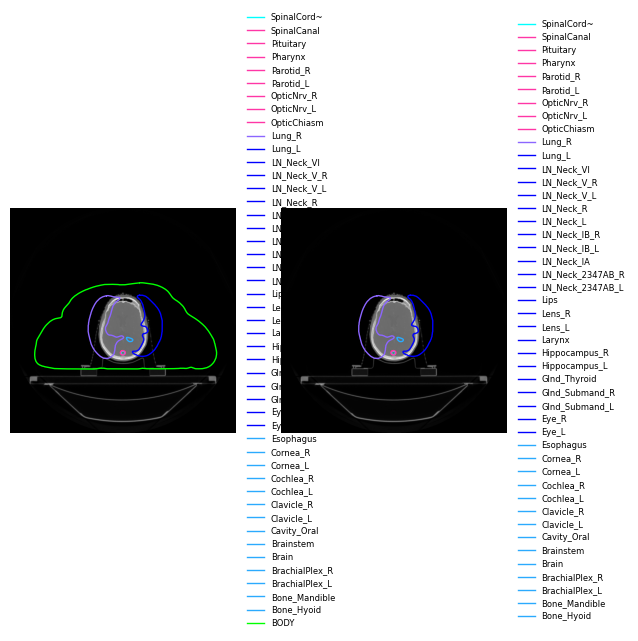

In [1321]:
plt.subplot(1,2,1)
plot_all_contours(RS_new,anon_image,sli,origin,spacing,ignore_terms = [
                                                               ],legend=True)

plt.subplot(1,2,2)
plot_all_contours(RS_old,image,sli,origin,spacing,ignore_terms = [
                                                               ],legend=True)

In [1322]:
file_dict[p]


{'CT': '/mnt/iDriveShare/Kayla/CBCT_images/kayla_extracted/755/20170217_CT_16_JAN_2017/CT.1.2.246.352.221.56518085876875079907494319526174120620.dcm',
 'RS_A': '/mnt/iDriveShare/Kayla/CBCT_images/anonymized/limbus_RS/RS.1.2.246.352.205.5497165284361287269.336238748074122654.dcm',
 'RS_1': '/mnt/iDriveShare/Kayla/CBCT_images/anonymized/limbus_RS_OG/RS.1.2.826.0.1.3680043.8.498.50991965776574594073972939044943935841.dcm'}

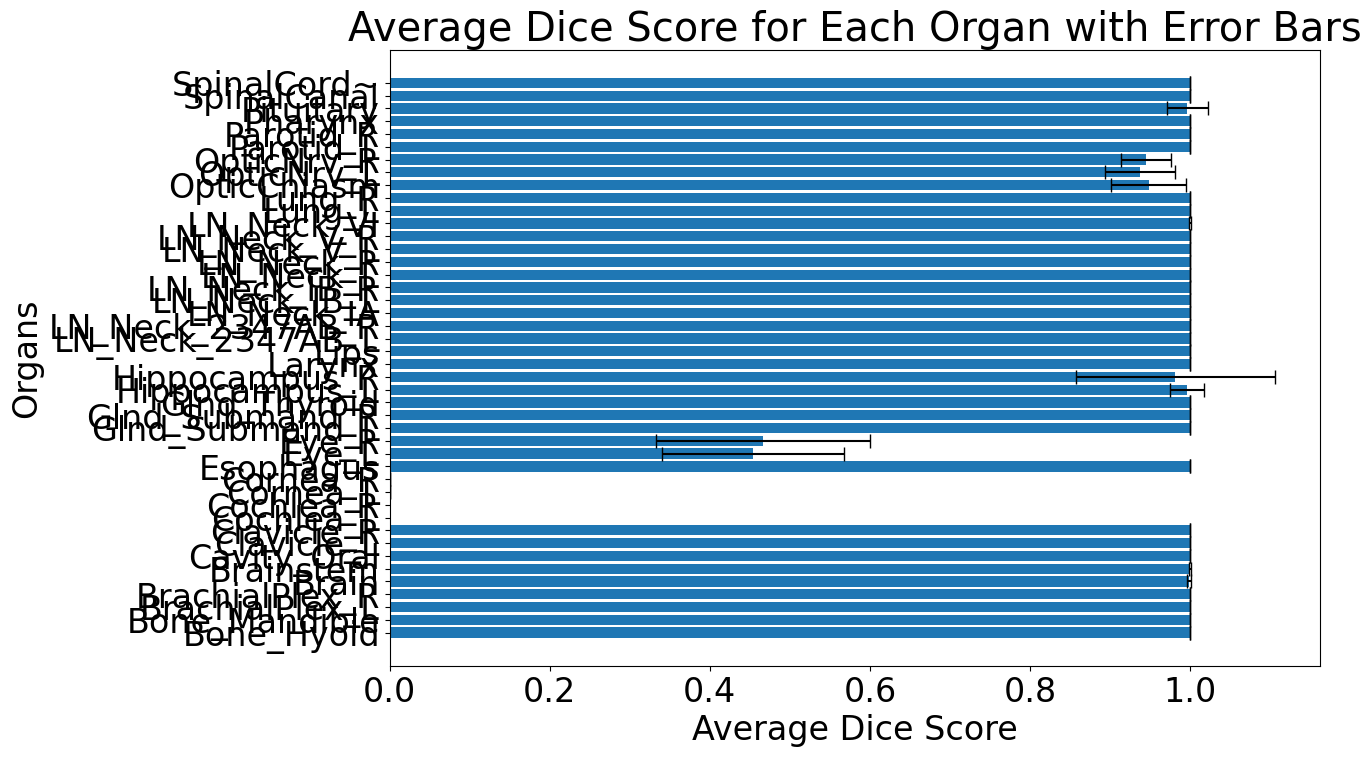

In [73]:
organ_means = {organ: np.mean(scores) for organ, scores in dict_organs.items()}
organ_stddevs = {organ: np.std(scores) for organ, scores in dict_organs.items()}

# Plotting
organs = list(organ_means.keys())
means = list(organ_means.values())
stddevs = list(organ_stddevs.values())

plt.figure(figsize=(12, 8))
plt.barh(organs, means, xerr=stddevs, capsize=5)
plt.xlabel('Average Dice Score')
plt.ylabel('Organs')
plt.title('Average Dice Score for Each Organ with Error Bars')
plt.show()

In [74]:
dict_DSC

NameError: name 'dict_DSC' is not defined

In [75]:
for o in organ_means:
    print(o,":",organ_means[o],'+/-',organ_stddevs[o])

Bone_Hyoid : 1.0 +/- 0.0
Bone_Mandible : 1.0 +/- 0.0
BrachialPlex_L : 1.0 +/- 0.0
BrachialPlex_R : 1.0 +/- 0.0
Brain : 0.9984347829889404 +/- 0.002448946635692073
Brainstem : 0.9998678282456785 +/- 0.0010490807768449902
Cavity_Oral : 1.0 +/- 0.0
Clavicle_L : 1.0 +/- 0.0
Clavicle_R : 1.0 +/- 0.0
Cochlea_L : nan +/- nan
Cochlea_R : nan +/- nan
Cornea_L : 0.0 +/- 0.0
Cornea_R : 0.0 +/- 0.0
Esophagus : 1.0 +/- 0.0
Eye_L : 0.4541592411607795 +/- 0.11385669804617343
Eye_R : 0.46655366498600004 +/- 0.13368995910230413
Glnd_Submand_L : 1.0 +/- 0.0
Glnd_Submand_R : 1.0 +/- 0.0
Glnd_Thyroid : 1.0 +/- 0.0
Hippocampus_L : 0.9962445155833827 +/- 0.02091598644599865
Hippocampus_R : 0.9817104083802856 +/- 0.12484761403954106
Larynx : 1.0 +/- 0.0
Lips : 1.0 +/- 0.0
LN_Neck_2347AB_L : 1.0 +/- 0.0
LN_Neck_2347AB_R : 1.0 +/- 0.0
LN_Neck_IA : 1.0 +/- 0.0
LN_Neck_IB_L : 1.0 +/- 0.0
LN_Neck_IB_R : 1.0 +/- 0.0
LN_Neck_L : 1.0 +/- 0.0
LN_Neck_R : 1.0 +/- 0.0
LN_Neck_V_L : 1.0 +/- 0.0
LN_Neck_V_R : 1.0 +/- 0.0

In [76]:
# dcm.read_file(og_RS_path+'RS.1.2.826.0.1.3680043.8.498.92111241876127827867792484102989368007.dcm')

In [77]:
plt.rcParams.update({'font.size': 24})

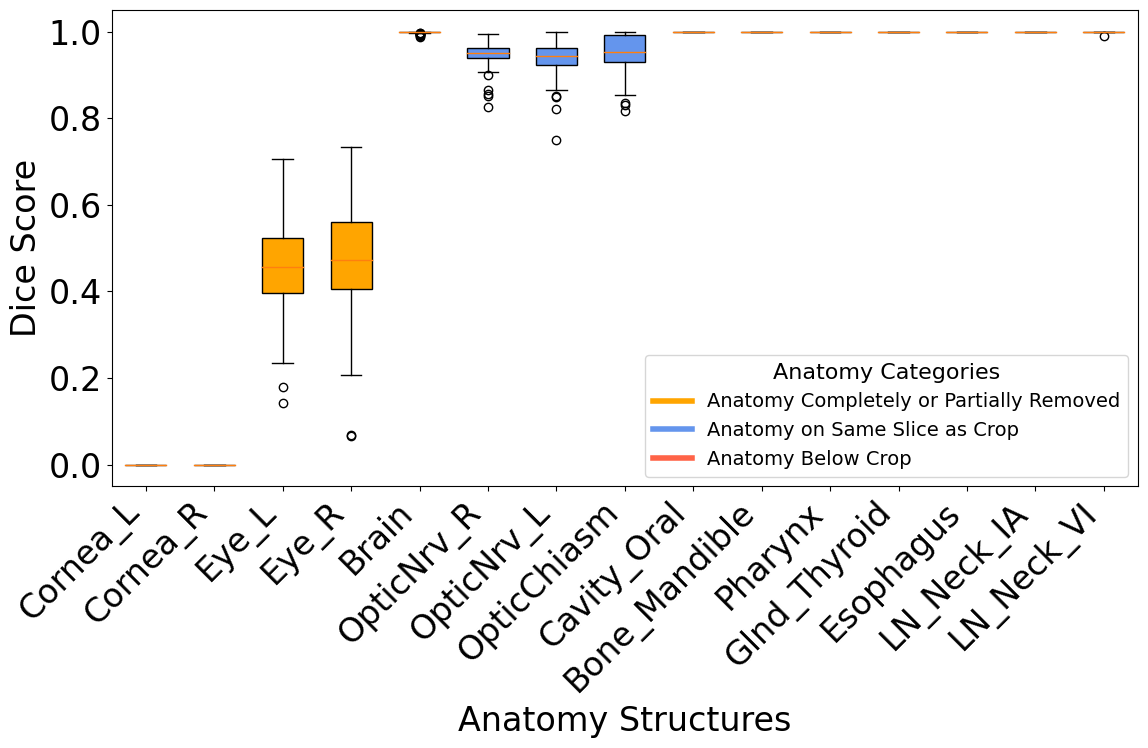

In [78]:
selected_organs = [ 'Cornea_L', 'Cornea_R', 'Eye_L', 'Eye_R', 'Brain', 'OpticNrv_R', 'OpticNrv_L', 'OpticChiasm', 'Cavity_Oral', 'Bone_Mandible','Pharynx', 'Glnd_Thyroid','Esophagus', 'LN_Neck_IA','LN_Neck_VI'] # Filter the data 
filtered_data = {organ: dict_organs[organ] for organ in selected_organs}
labels = list(filtered_data.keys()) 
data = list(filtered_data.values()) 
colors = ['orange'] * 4 + ['cornflowerblue'] * 4 + ['tomato'] * 7 # Define colors for the groups 
fig, ax = plt.subplots(figsize=(12, 8)) # Create box plots 
for i in range(len(labels)): 
    ax.boxplot(filtered_data[labels[i]], positions=[i], widths=0.6, patch_artist=True, boxprops=dict(facecolor=colors[i])) 
    # Add some text for labels, title and custom x-axis tick labels, etc. 
ax.set_ylabel('Dice Score') 
ax.set_xlabel('Anatomy Structures') 
ax.set_xticks(np.arange(len(labels))) 
ax.set_xticklabels(labels, rotation=45, ha='right') 
# ax.invert_yaxis() # Invert y axis to have the first item at the top # Add legend 
legend_labels = ['Anatomy Completely or Partially Removed', 'Anatomy on Same Slice as Crop', 'Anatomy Below Crop'] 
handles = [plt.Line2D([0], [0], color=c, lw=4) 
           for c in ['orange', 'cornflowerblue', 'tomato']] 
ax.legend(handles, legend_labels, fontsize=14, title='Anatomy Categories', title_fontsize='16') 
fig.tight_layout() 
plt.show()

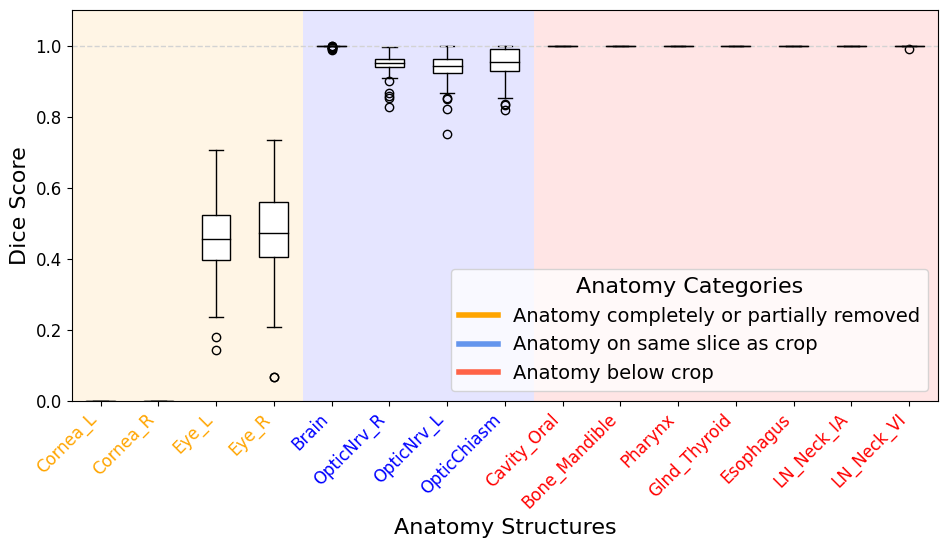

In [79]:

colors = ['orange'] * 4 + ['blue'] * 4 + ['red'] * 7  # Define colors for the groups

fig, ax = plt.subplots(figsize=(10, 6))

# Create background shading for each category
for i in range(len(colors)):
    ax.axvspan(i + 0.5, i + 1.5, facecolor=colors[i], alpha=0.1)

# Create box plots with white boxes
boxplots = ax.boxplot(data, vert=True, patch_artist=True)

# Customize the box plot colors
for patch in boxplots['boxes']:
    patch.set_facecolor('white')
    patch.set_edgecolor('black')

# Set the mean and quartile lines to black
for partname in ('whiskers', 'caps', 'medians', 'fliers'):
    plt.setp(boxplots[partname], color='black')

# Add some text for labels, title and custom y-axis tick labels, etc.
ax.set_ylabel('Dice Score',fontsize=16)
ax.set_xlabel('Anatomy Structures',fontsize=16)
ax.set_xticks(np.arange(1, len(labels) + 1))
ax.set_xticklabels(labels, rotation=45, ha='right',fontsize=12)
ax.axhline(y=1, color='lightgray', linestyle='--', linewidth=1)



# Highlight the labels on the x-axis
for i, label in enumerate(ax.get_xticklabels()):
    label.set_color(colors[i])

# Adjust y-axis to display 1 at the top, 0 at the bottom, and extend beyond 1
ax.set_ylim(0, 1.1)
ax.set_yticks(np.arange(0, 1.1, 0.2))
ax.set_yticklabels([f'{tick:.1f}' for tick in np.arange(0, 1.1, 0.2)],fontsize=12)

# Add legend
legend_labels = ['Anatomy completely or partially removed', 'Anatomy on same slice as crop', 'Anatomy below crop']
handles = [plt.Line2D([0], [0], color=c, lw=4) for c in ['orange', 'cornflowerblue', 'tomato']]
ax.legend(handles, legend_labels, fontsize=14, title='Anatomy Categories', title_fontsize='16')

fig.tight_layout()

plt.show()


In [1406]:
print(organs)

['Bone_Hyoid', 'Bone_Mandible', 'BrachialPlex_L', 'BrachialPlex_R', 'Brain', 'Brainstem', 'Cavity_Oral', 'Clavicle_L', 'Clavicle_R', 'Cochlea_L', 'Cochlea_R', 'Cornea_L', 'Cornea_R', 'Esophagus', 'Eye_L', 'Eye_R', 'Glnd_Submand_L', 'Glnd_Submand_R', 'Glnd_Thyroid', 'Hippocampus_L', 'Hippocampus_R', 'LN_Neck_2347AB_L', 'LN_Neck_2347AB_R', 'LN_Neck_IA', 'LN_Neck_IB_L', 'LN_Neck_IB_R', 'LN_Neck_L', 'LN_Neck_R', 'LN_Neck_VI', 'LN_Neck_V_L', 'LN_Neck_V_R', 'Larynx', 'Lips', 'Lung_L', 'Lung_R', 'OpticChiasm', 'OpticNrv_L', 'OpticNrv_R', 'Parotid_L', 'Parotid_R', 'Pharynx', 'Pituitary', 'SpinalCanal', 'SpinalCord~']


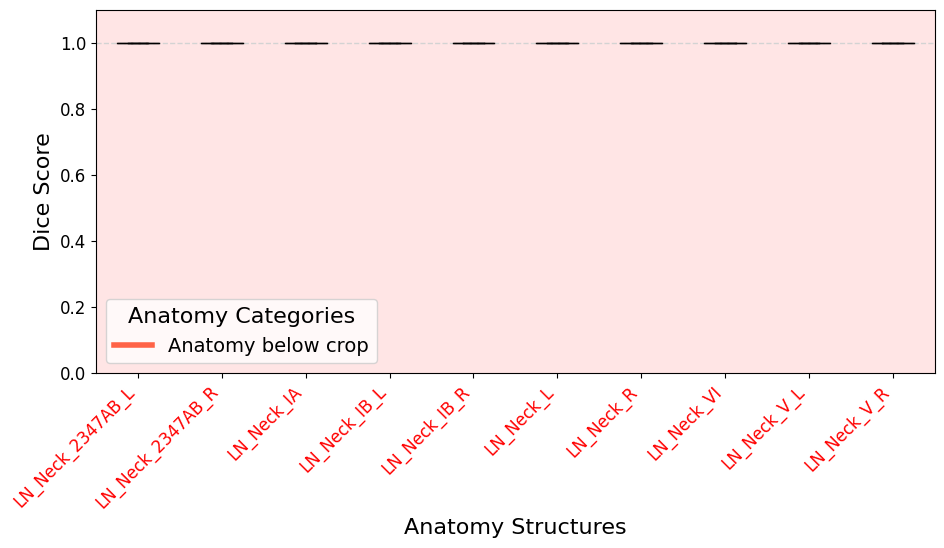

In [70]:
LNs = ['LN_Neck_2347AB_L', 'LN_Neck_2347AB_R', 'LN_Neck_IA', 'LN_Neck_IB_L', 'LN_Neck_IB_R', 'LN_Neck_L', 'LN_Neck_R', 'LN_Neck_VI', 'LN_Neck_V_L', 'LN_Neck_V_R']
LNs_data = {organ: dict_organs[organ] for organ in LNs}
labels = list(LNs_data.keys()) 
data = list(LNs_data.values()) 
colors = ['red'] * len(LNs) 

fig, ax = plt.subplots(figsize=(10, 6))

# Create background shading for each category
for i in range(len(colors)):
    ax.axvspan(i + 0.5, i + 1.5, facecolor=colors[i], alpha=0.1)

# Create box plots with white boxes
boxplots = ax.boxplot(data, vert=True, patch_artist=True)

# Customize the box plot colors
for patch in boxplots['boxes']:
    patch.set_facecolor('white')
    patch.set_edgecolor('black')

# Set the mean and quartile lines to black
for partname in ('whiskers', 'caps', 'medians', 'fliers'):
    plt.setp(boxplots[partname], color='black')

# Add some text for labels, title and custom y-axis tick labels, etc.
ax.set_ylabel('Dice Score',fontsize=16)
ax.set_xlabel('Anatomy Structures',fontsize=16)
ax.set_xticks(np.arange(1, len(labels) + 1))
ax.set_xticklabels(labels, rotation=45, ha='right',fontsize=12)
ax.axhline(y=1, color='lightgray', linestyle='--', linewidth=1)



# Highlight the labels on the x-axis
for i, label in enumerate(ax.get_xticklabels()):
    label.set_color(colors[i])

# Adjust y-axis to display 1 at the top, 0 at the bottom, and extend beyond 1
ax.set_ylim(0, 1.1)
ax.set_yticks(np.arange(0, 1.1, 0.2))
ax.set_yticklabels([f'{tick:.1f}' for tick in np.arange(0, 1.1, 0.2)],fontsize=12)

# Add legend
legend_labels = ['Anatomy below crop']
handles = [plt.Line2D([0], [0], color=c, lw=4) for c in ['tomato']]
ax.legend(handles, legend_labels, fontsize=14, title='Anatomy Categories', title_fontsize='16')

fig.tight_layout()

plt.show()


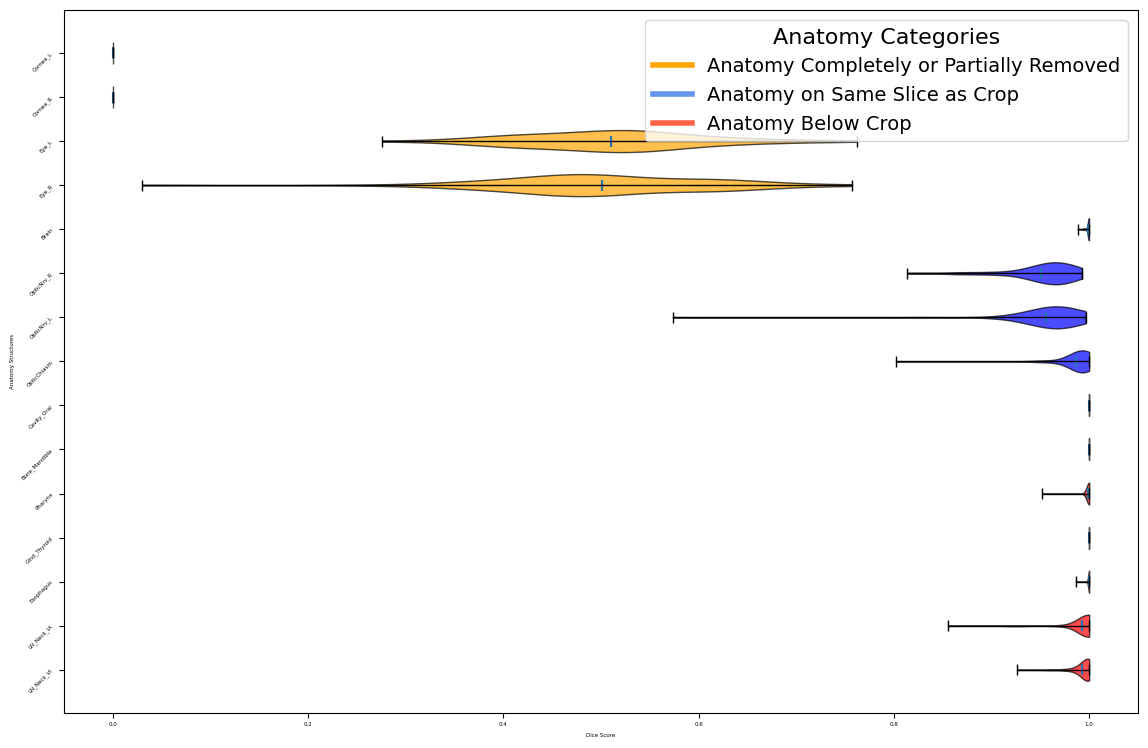

In [1019]:

fig, ax = plt.subplots(figsize=(12, 8))
# Create violin plots
violins = ax.violinplot(data, vert=False, showmeans=True)

# Customize the violin plot colors
for i, violin in enumerate(violins['bodies']):
    violin.set_facecolor(colors[i])
    violin.set_edgecolor('black')
    violin.set_alpha(0.7)

# Set the mean and quartile lines to black 
for partname in ('cbars', 'cmins', 'cmaxes'): 
    vp = violins[partname] 
    vp.set_edgecolor('black') 
    vp.set_linewidth(1)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Dice Score')
ax.set_ylabel('Anatomy Structures')
ax.set_yticks(np.arange(1, len(labels) + 1))
ax.set_yticklabels(labels, rotation=45, ha='right')
ax.invert_yaxis()  # Invert y axis to have the first item at the top

# Add legend
legend_labels = ['Anatomy Completely or Partially Removed', 'Anatomy on Same Slice as Crop', 'Anatomy Below Crop']
handles = [plt.Line2D([0], [0], color=c, lw=4) for c in ['orange', 'cornflowerblue', 'tomato']]
ax.legend(handles, legend_labels, fontsize=14, title='Anatomy Categories', title_fontsize='16')

fig.tight_layout()

plt.show()



In [1407]:
not_one = []
for organ, scores in dict_organs.items():
    mean_score = np.mean(scores)
    if mean_score != 1:
        not_one.append(organ)
    std_dev = np.std(scores)
    print(f"{organ}: Mean DSC= {mean_score:.4f}, Stddev = {std_dev:.4f}")

Bone_Hyoid: Mean DSC= 1.0000, Stddev = 0.0000
Bone_Mandible: Mean DSC= 1.0000, Stddev = 0.0000
BrachialPlex_L: Mean DSC= 1.0000, Stddev = 0.0000
BrachialPlex_R: Mean DSC= 1.0000, Stddev = 0.0000
Brain: Mean DSC= 0.9988, Stddev = 0.0020
Brainstem: Mean DSC= 1.0000, Stddev = 0.0000
Cavity_Oral: Mean DSC= 1.0000, Stddev = 0.0000
Clavicle_L: Mean DSC= 1.0000, Stddev = 0.0000
Clavicle_R: Mean DSC= 1.0000, Stddev = 0.0000
Cochlea_L: Mean DSC= nan, Stddev = nan
Cochlea_R: Mean DSC= nan, Stddev = nan
Cornea_L: Mean DSC= 0.0000, Stddev = 0.0000
Cornea_R: Mean DSC= 0.0000, Stddev = 0.0000
Esophagus: Mean DSC= 0.9999, Stddev = 0.0003
Eye_L: Mean DSC= 0.4775, Stddev = 0.1006
Eye_R: Mean DSC= 0.4683, Stddev = 0.1167
Glnd_Submand_L: Mean DSC= 1.0000, Stddev = 0.0000
Glnd_Submand_R: Mean DSC= 1.0000, Stddev = 0.0000
Glnd_Thyroid: Mean DSC= 1.0000, Stddev = 0.0000
Hippocampus_L: Mean DSC= 1.0000, Stddev = 0.0000
Hippocampus_R: Mean DSC= 1.0000, Stddev = 0.0000
LN_Neck_2347AB_L: Mean DSC= 1.0000, Stdde

In [1410]:
dict_DSC2['2041']

{'Lung_L': 1.0,
 'LN_Neck_VI': 1.0,
 'LN_Neck_V_R': 1.0,
 'SpinalCord~': 1.0,
 'SpinalCanal': 1.0,
 'Pituitary': 1.0,
 'Pharynx': 1.0,
 'Parotid_R': 1.0,
 'Parotid_L': 1.0,
 'OpticNrv_R': 0.968421052631579,
 'OpticNrv_L': 0.9479768786127167,
 'OpticChiasm': 0.9961389961389961,
 'Lung_R': 1.0,
 'Hippocampus_L': 1.0,
 'Glnd_Thyroid': 1.0,
 'Glnd_Submand_R': 1.0,
 'LN_Neck_V_L': 1.0,
 'LN_Neck_R': 1.0,
 'LN_Neck_L': 1.0,
 'LN_Neck_IB_R': 1.0,
 'LN_Neck_IB_L': 1.0,
 'LN_Neck_IA': 0.9917355371900827,
 'LN_Neck_2347AB_R': 1.0,
 'LN_Neck_2347AB_L': 1.0,
 'Lips': 1.0,
 'Larynx': 1.0,
 'Hippocampus_R': 1.0,
 'Brainstem': 1.0,
 'Brain': 0.9998293374067059,
 'BrachialPlex_R': 1.0,
 'Glnd_Submand_L': 1.0,
 'Eye_R': 0.6447656592203241,
 'Eye_L': 0.3650872817955112,
 'Esophagus': 1.0,
 'Cornea_R': 0.0,
 'Cornea_L': 0.0,
 'Cochlea_R': 1.0,
 'Cochlea_L': 1.0,
 'Clavicle_R': 1.0,
 'Clavicle_L': 1.0,
 'Cavity_Oral': 1.0,
 'BrachialPlex_L': 1.0,
 'Bone_Mandible': 1.0,
 'Bone_Hyoid': 1.0}

In [1408]:
not_one

['Brain',
 'Cochlea_L',
 'Cochlea_R',
 'Cornea_L',
 'Cornea_R',
 'Esophagus',
 'Eye_L',
 'Eye_R',
 'LN_Neck_IA',
 'LN_Neck_VI',
 'OpticChiasm',
 'OpticNrv_L',
 'OpticNrv_R',
 'Pituitary']

In [1022]:
Bone_Hyoid: Mean DSC= 1.0000, Stddev = 0.0000
Bone_Mandible: Mean DSC= 1.0000, Stddev = 0.0000
BrachialPlex_L: Mean DSC= 1.0000, Stddev = 0.0000
BrachialPlex_R: Mean DSC= 1.0000, Stddev = 0.0000
Brain: Mean DSC= 0.9990, Stddev = 0.0014
Brainstem: Mean DSC= 1.0000, Stddev = 0.0000
Cavity_Oral: Mean DSC= 1.0000, Stddev = 0.0000
Clavicle_L: Mean DSC= 1.0000, Stddev = 0.0000
Clavicle_R: Mean DSC= 1.0000, Stddev = 0.0000
Cochlea_L: Mean DSC= nan, Stddev = nan
Cochlea_R: Mean DSC= nan, Stddev = nan
Cornea_L: Mean DSC= 0.0000, Stddev = 0.0000
Cornea_R: Mean DSC= 0.0000, Stddev = 0.0000
Esophagus: Mean DSC= 0.9998, Stddev = 0.0015
Eye_L: Mean DSC= 0.4864, Stddev = 0.0974
Eye_R: Mean DSC= 0.4673, Stddev = 0.1239
Glnd_Submand_L: Mean DSC= 1.0000, Stddev = 0.0000
Glnd_Submand_R: Mean DSC= 1.0000, Stddev = 0.0000
Glnd_Thyroid: Mean DSC= 1.0000, Stddev = 0.0000
Hippocampus_L: Mean DSC= 1.0000, Stddev = 0.0000
Hippocampus_R: Mean DSC= 1.0000, Stddev = 0.0000
Larynx: Mean DSC= 1.0000, Stddev = 0.0000
Lips: Mean DSC= 1.0000, Stddev = 0.0000
LN_Neck_2347AB_L: Mean DSC= 1.0000, Stddev = 0.0000
LN_Neck_2347AB_R: Mean DSC= 1.0000, Stddev = 0.0000
LN_Neck_IA: Mean DSC= 0.9793, Stddev = 0.0660
LN_Neck_IB_L: Mean DSC= 1.0000, Stddev = 0.0000
LN_Neck_IB_R: Mean DSC= 1.0000, Stddev = 0.0000
LN_Neck_L: Mean DSC= 1.0000, Stddev = 0.0000
LN_Neck_R: Mean DSC= 1.0000, Stddev = 0.0000
LN_Neck_V_L: Mean DSC= 1.0000, Stddev = 0.0000
LN_Neck_V_R: Mean DSC= 1.0000, Stddev = 0.0000
LN_Neck_VI: Mean DSC= 0.9915, Stddev = 0.0166
Lung_L: Mean DSC= 0.9997, Stddev = 0.0023
Lung_R: Mean DSC= 0.9996, Stddev = 0.0029
OpticChiasm: Mean DSC= 0.9892, Stddev = 0.0128
OpticNrv_L: Mean DSC= 0.9561, Stddev = 0.0271
OpticNrv_R: Mean DSC= 0.9397, Stddev = 0.0430
Parotid_L: Mean DSC= 1.0000, Stddev = 0.0000
Parotid_R: Mean DSC= 1.0000, Stddev = 0.0000
Pharynx: Mean DSC= 1.0000, Stddev = 0.0000
Pituitary: Mean DSC= nan, Stddev = nan
SpinalCanal: Mean DSC= 0.9999, Stddev = 0.0007
SpinalCord~: Mean DSC= 0.9999, Stddev = 0.0007

SyntaxError: invalid syntax (4083395390.py, line 1)

In [499]:
for p in patients_to_change:
    if p not in dict_DSC:
        print(p)

462
673


In [500]:
dict_organs['OpticNrv_L']

[0.9759036144578314,
 0.991869918699187,
 0.9447852760736196,
 0.9130434782608695,
 0.979381443298969,
 0.9733333333333334,
 0.9707602339181286,
 0.9583333333333334,
 0.9765258215962441,
 0.9056603773584906,
 0.9696969696969697,
 0.927710843373494,
 0.9565217391304348,
 0.8235294117647058,
 0.9875518672199171,
 0.9193548387096774,
 0.9372384937238494,
 0.9821428571428571,
 0.9172932330827067,
 0.9666666666666667,
 0.9285714285714286,
 1.0,
 0.9759615384615384,
 0.9433962264150944,
 0.9595375722543352,
 0.9787234042553191,
 0.9508196721311475,
 0.9736842105263158,
 0.946236559139785,
 0.9751243781094527,
 0.9230769230769231,
 0.9882352941176471,
 0.9680851063829787,
 0.9536423841059603,
 0.9565217391304348,
 0.9571428571428572,
 0.9873417721518988,
 0.9430051813471503,
 0.9887640449438202,
 0.9312169312169312,
 0.9726775956284153,
 0.9508196721311475,
 0.9915966386554622,
 1.0,
 0.9620253164556962,
 0.8661417322834646,
 0.9790794979079498,
 0.9438202247191011,
 0.9281767955801105,
 0.96

# PTV Cutoff

In [501]:
remove = ['495','1036','980','1053','1074','1132','1262','1271','1275','1311','1341','1343','1380',
'1393','1396','1434','1462','1464','1481','652','715','740','742','757','780','821','827',
'862','1522','1686']
print(len(remove))
remove = []

30


In [11]:
list_all_patients = sorted([p for p in os.listdir(PATH) if 'b' not in p and 'old' not in p and p not in remove], key=int,reverse=False)
print(len(list_all_patients))

630


In [17]:
patient_list = [19, 22, 23, 35, 43, 51, 54, 59, 60, 70, 77, 81, 100, 101, 103, 108, 112, 115, 118, 146, 147, 153, 169, 172, 257, 272, 274, 294, 359, 384, 390, 408, 424, 425, 432, 436, 437, 439, 440, 443, 447, 448, 451, 452, 453, 454, 456, 459, 460, 462, 463, 464, 466, 467, 468, 469, 471, 473, 474, 476, 478, 483, 484, 487, 490, 498, 502, 503, 504, 506, 507, 509, 510, 512, 513, 514, 515, 517, 518, 520, 600, 602, 604, 606, 607, 611, 613, 614, 615, 616, 617, 618, 619, 621, 622, 623, 624, 625, 628, 629, 630, 631, 632, 633, 634, 635, 637, 638, 639, 640, 641, 644, 645, 646, 647, 648, 651, 653, 655, 656, 657, 659, 660, 661, 662, 663, 665, 666, 667, 668, 670, 671, 672, 673, 674, 675, 676, 677, 679, 680, 681, 682, 684, 685, 688, 689, 690, 692, 694, 695, 696, 700, 702, 703, 704, 707, 709, 710, 711, 713, 714, 718, 719, 721, 722, 723, 725, 726, 728, 729, 730, 734, 735, 736, 737, 738, 743, 744, 746, 747, 748, 749, 750, 751, 753, 754, 755, 758, 759, 760, 761, 764, 765, 766, 767, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 781, 782, 783, 784, 786, 787, 788, 789, 790, 791, 793, 794, 797, 798, 799, 800, 801, 802, 803, 804, 805, 808, 811, 812, 813, 814, 817, 820, 822, 823, 825, 826, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 841, 842,  843, 844, 845, 846, 847, 848, 850, 851, 852, 853, 855, 856, 857, 858, 859, 860, 861, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 927, 928, 929, 931, 932, 933, 934, 935, 936, 937, 938, 939, 941, 942, 943, 944, 945, 946, 949, 950, 951, 952, 953, 954, 955, 956, 957, 960, 961, 962, 963, 964, 965, 966, 967, 968, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 990, 991, 1001, 1013, 1019, 1021, 1026, 1027, 1044, 1056, 1058, 1059, 1071, 1075, 1081, 1100, 1109, 1130, 1143, 1145, 1149, 1165, 1167, 1177, 1184, 1188, 1189, 1198, 1209, 1215, 1221, 1233, 1252, 1254, 1255, 1268, 1269, 1288, 1289, 1296, 1306, 1314, 1317, 1325, 1328, 1331, 1332, 1333, 1340, 1350, 1360, 1364, 1374, 1381, 1400, 1402, 1428, 1432, 1433, 1438, 1443, 1444, 1449, 1461, 1466, 1467, 1470, 1471, 1482, 1488, 1489, 1493, 1494, 1497, 1502, 1503, 1506, 1508, 1511, 1514, 1515, 1518, 1520, 1521, 1523, 1525, 1527, 1530, 1538, 1544, 1545, 1546, 1549, 1550, 1551, 1552, 1558, 1559, 1563, 1565, 1570, 1575, 1594, 1598, 1607, 1603, 1611, 1624, 1634, 1641, 1645, 1651, 1655, 1659, 1662, 1665, 1667, 1670, 1671, 1673, 1675, 1678, 1694, 1695, 1696, 1699, 1700, 1714, 1723, 1724, 1726, 1727, 1730, 1736, 1759, 1761, 1763, 1765, 1766, 1774, 1780, 1781, 1783, 1787, 1790, 1804, 1806, 1809, 1821, 1822, 1824, 1826, 1831, 1832, 1834, 1838, 1844, 1850, 1856, 1857, 1860, 1865, 1870, 1873, 1876, 1880, 1886, 1888, 1889, 1891, 1892, 1893, 1895, 1898, 1899, 1901, 1902, 1905, 1907, 1911, 1918, 1923, 1932, 1935, 1940, 1942, 1944, 1949, 1950, 1951, 1954, 1955, 1960, 1961, 1965, 1969, 1974, 1978, 1982, 1987, 1991, 1994, 1995, 1999, 2000, 2003, 2013, 2015, 2017, 2018, 2019, 2020, 2021, 2022, 2026, 2027, 2030, 2031, 2033, 2035, 2036, 2037, 2040,2041, 2042, 2043, 2044,2045, 2047, 2048, 2051, 2054, 2055, 2056, 2057, 2058, 2059, 2061, 2062, 2066, 2068, 2073, 2074, 2075, 2076, 2078]
print(len(patient_list))

622


In [18]:
list_all_patients = patient_list

In [16]:
p_prev = 0
for p in patient_list:
    if p == p_prev:
    # if int(p) not in patient_list:
        print(p)
    p_prev = p

704
730


In [104]:
PTV_cutoffs = {}
no_eyes = []
for p in list_all_patients:
    print("******", p , "*******")
    p = str(p)
    if p=='853':
        continue
    patient_path = PATH+p+'/'
    CT_list = [d for d in os.listdir(patient_path) if d[9:11] == 'CT' and len(d) == 23]
    if len(CT_list) > 2:
        print(p,"has",len(CT_list),"CTs.")
    PTV_cutoffs[p] = {}    
    for CT in CT_list:
        print(CT)
        CT_path = patient_path+CT+'/'
        RS_file = [rs for rs in os.listdir(CT_path) if 'RS' in rs][0]
        RS = dcm.read_file(CT_path+RS_file)
        
#         print(p, CT, RS_file)
        
        
        eye_ROI_names = find_ROI_names(RS,keyword='eye')
        
        if len(eye_ROI_names) != 2:
            print(p, eye_ROI_names)
        if len(eye_ROI_names) == 0:
            
            eye_ROI_names = find_ROI_names(RS,keyword='orbit')
            if len(eye_ROI_names) == 0:
                 eye_ROI_names = find_ROI_names(RS,keyword='globe')
            if len(eye_ROI_names) == 0:
                print("***Patient", p, "CT",CT, "has no eye contours... ***")
                no_eyes.append(p)
                print(find_ROI_names(RS))
                continue
   
            
        dict_contours, z_lists = get_all_ROI_contours(eye_ROI_names, RS)
#         all_z_slices = sorted(z_lists[0] + [z for z in z_lists[1] if z not in z_lists[0]])
        all_z_slices = []
        for z_list in z_lists:
            all_z_slices = sorted(all_z_slices + [z for z in z_list if z not in all_z_slices])
        
        PTV_names = [p for p in find_ROI_names(RS,"PTV") if '!' not in p and 'z' not in p.lower() and 'E-PTV' not in p and 'NON' not in p and '-ptv' not in p.lower() and 'avoid' not in p.lower() and 'old' not in p.lower() and p!='ptv70+0.3']
        print(PTV_names)
        PTV_dict_contours, z_lists = get_all_ROI_contours(PTV_names, RS)
        
        all_z_slices_PTV = []
        for z_list in z_lists:
            all_z_slices_PTV = sorted(all_z_slices_PTV + [z for z in z_list if z not in all_z_slices_PTV])
        
        PTV_slices_cut = 0
        len_PTV_slices = len(all_z_slices_PTV)
        
        for z in all_z_slices_PTV:
            if z in all_z_slices or z>min(all_z_slices):
                PTV_slices_cut += 1
        
        
        PTV_cutoffs[p][CT] = {}
        PTV_cutoffs[p][CT]['total'] = len_PTV_slices
        PTV_cutoffs[p][CT]['cut'] = PTV_slices_cut
        
        

        

****** 19 *******
20180411_CT_09_APR_2018
['PTV70+PTV60', 'PTV_ALL', 'PTV70', 'PTV60', 'PTV56']
20180515_CT_10_MAY_2018
['MOD1_PTV70+PTV60', 'MOD1_PTV_ALL', 'MOD1_PTV70', 'MOD1_PTV60', 'MOD1_PTV56', 'PTV70+PTV60', 'PTV_ALL', 'PTV56', 'PTV60', 'PTV70']
****** 22 *******
20180921_CT_13_SEP_2018
['PTV_7000', 'PTV_6300', 'PTV_5600', 'PTV_ALL', 'opt_PTV56_cover', 'MOD_PTV_5600']
****** 23 *******
20180831_CT_22_AUG_2018
['PTV70+PTV60', 'PTV_ALL', 'PTV70', 'PTV60', 'PTV56', 'PTV56_opt', 'PTV60opt']
****** 35 *******
20180209_CT_06_FEB_2018
['PTV56', 'PTV60', 'PTV70', 'MOD1_PTV56', 'MOD1_PTV60', 'MOD1_PTV70', 'MOD1_PTV70+PTV60', 'MOD1_PTV_ALL']
20171220_CT_14_DEC_2017
['PTV_ALL', 'PTV60+PTV70', 'PTV70', 'PTV60', 'PTV56']
****** 43 *******
20250207_CT_24_JAN_2019
['PTV_7000-05']
****** 51 *******
20190430_CT_24_APR_2019
['PTV_7000', 'PTV_5600']
****** 54 *******
20190122_CT_14_JAN_2019
['PTV_7000-05', 'PTV_Eval_7000']
20190225_CT_19_FEB_2019
['M1 PTV_7000-05', 'M1 PTV_EVAL_7000']
****** 59 ***

In [29]:
PTV_cutoffs

{'19': {'20180411_CT_09_APR_2018': {'total': 92, 'cut': 0},
  '20180515_CT_10_MAY_2018': {'total': 92, 'cut': 0}},
 '22': {'20180921_CT_13_SEP_2018': {'total': 65, 'cut': 0}},
 '23': {'20180831_CT_22_AUG_2018': {'total': 96, 'cut': 0}},
 '35': {'20180209_CT_06_FEB_2018': {'total': 94, 'cut': 0},
  '20171220_CT_14_DEC_2017': {'total': 93, 'cut': 0}},
 '43': {'20250207_CT_24_JAN_2019': {'total': 15, 'cut': 0}},
 '51': {'20190430_CT_24_APR_2019': {'total': 77, 'cut': 0}},
 '54': {'20190122_CT_14_JAN_2019': {'total': 49, 'cut': 11},
  '20190225_CT_19_FEB_2019': {'total': 40, 'cut': 13}},
 '59': {'20180807_CT_31_JUL_2018': {'total': 104, 'cut': 4},
  '20180705_CT_27_JUN_2018': {'total': 140, 'cut': 5}},
 '60': {'20181004_CT_26_SEP_2018': {'total': 84, 'cut': 0}},
 '70': {'20180221_CT_14_FEB_2018': {'total': 88, 'cut': 0},
  '20180403_CT_28_MAR_2018': {'total': 120, 'cut': 0}},
 '77': {'20190320_CT_13_MAR_2019': {'total': 29, 'cut': 0}},
 '81': {'20190125_CT_16_JAN_2019': {'total': 97, 'cut'

In [57]:
PTV_cutoffs

{'19': {},
 '22': {},
 '23': {},
 '35': {},
 '43': {},
 '51': {},
 '54': {},
 '59': {},
 '60': {},
 '70': {},
 '77': {},
 '81': {},
 '100': {},
 '101': {},
 '103': {},
 '108': {},
 '112': {},
 '115': {},
 '118': {},
 '146': {},
 '147': {},
 '153': {},
 '169': {},
 '172': {},
 '257': {},
 '272': {},
 '274': {},
 '294': {},
 '359': {},
 '384': {},
 '390': {},
 '408': {},
 '424': {},
 '425': {},
 '432': {},
 '436': {},
 '437': {},
 '439': {},
 '440': {},
 '443': {},
 '447': {},
 '448': {},
 '451': {},
 '452': {},
 '453': {},
 '454': {},
 '456': {},
 '459': {},
 '460': {},
 '462': {},
 '463': {},
 '464': {},
 '466': {},
 '467': {},
 '468': {},
 '469': {},
 '471': {},
 '473': {},
 '474': {},
 '476': {},
 '478': {},
 '483': {},
 '484': {},
 '487': {},
 '490': {},
 '498': {},
 '502': {},
 '503': {},
 '504': {},
 '506': {},
 '507': {},
 '509': {},
 '510': {},
 '512': {},
 '513': {},
 '514': {},
 '515': {},
 '517': {},
 '518': {},
 '520': {},
 '600': {},
 '602': {},
 '604': {},
 '606': {},
 '60

In [61]:
remove = ['853']

In [64]:
# Number of patients counted
total_ps = 0
not_count = 0
for p in PTV_cutoffs:
    if p == '853':
        continue
    
    if bool(PTV_cutoffs[p]) and p not in remove:# and p!='1514':
        
        total_ps+=1
    else:
        print(p)
        not_count+=1

total_CTs = 0

for p in PTV_cutoffs:
    if p == '853':
        continue
    
    for CT in PTV_cutoffs[p]:
        if p not in remove:
            total_CTs+=1
        
print("Total patients with dirs:",len(list_all_patients)-len(remove))
print("Total patients counted:", total_ps)
print("Total CTs counted:",total_CTs)
print("Patients without eyes:",len(no_eyes)-1)

1611
1641
1645
1651
1655
1662
1694
1695
1699
1700
1726
1736
1761
1780
1787
1790
1809
1821
1822
1824
1832
1850
1860
1865
1873
1880
1886
1889
1899
1907
1940
1965
2020
2075
Total patients with dirs: 621
Total patients counted: 586
Total CTs counted: 792
Patients without eyes: 35


In [67]:
all_CT_count = 0
for p in list_all_patients:
    

    p = str(p)
    if p=='853':
        continue
    patient_path = PATH+p+'/'
    CT_list = [d for d in os.listdir(patient_path) if d[9:11] == 'CT' and len(d) == 23]
    all_CT_count += len(CT_list)
    if len(CT_list) > 1:
        print(p,CT_list)
    # if len(CT_list) > 2:
    #     print(p,"has",len(CT_list),"CTs.")

19 ['20180411_CT_09_APR_2018', '20180515_CT_10_MAY_2018']
35 ['20180209_CT_06_FEB_2018', '20171220_CT_14_DEC_2017']
54 ['20190122_CT_14_JAN_2019', '20190225_CT_19_FEB_2019']
59 ['20180807_CT_31_JUL_2018', '20180705_CT_27_JUN_2018']
70 ['20180221_CT_14_FEB_2018', '20180403_CT_28_MAR_2018']
81 ['20190125_CT_16_JAN_2019', '20190225_CT_22_FEB_2019']
118 ['20190603_CT_31_MAY_2019', '20190423_CT_10_APR_2019']
272 ['20180503_CT_25_APR_2018', '20180608_CT_06_JUN_2018']
274 ['20190912_CT_10_SEP_2019', '20190802_CT_25_JUL_2019']
384 ['20180611_CT_06_JUN_2018', '20180530_CT_24_MAY_2018']
437 ['20180305_CT_26_FEB_2018', '20180315_CT_06_MAR_2018']
447 ['20180329_CT_22_MAR_2018', '20180502_CT_01_MAY_2018']
448 ['20180410_CT_28_MAR_2018', '20180511_CT_08_MAY_2018']
452 ['20180606_CT_28_MAY_2018', '20180712_CT_11_JUL_2018']
454 ['20180822_CT_16_AUG_2018', '20180801_CT_24_JUL_2018']
459 ['20180614_CT_06_JUN_2018', '20180703_CT_27_JUN_2018']
462 ['20181017_CT_12_OCT_2018', '20181015_CT_05_SEP_2018']
467

In [66]:
all_CT_count

828

In [54]:
for p in no_eyes:
    CT_list = [d for d in os.listdir(PATH+p) if d[9:11] == 'CT' and len(d) == 23]
    for CT in CT_list:
        print("*****",p,"***")
        CT_path = PATH+p+'/'+CT+'/'
        print(CT)
        RS_file = [rs for rs in os.listdir(CT_path) if 'RS' in rs][0]
        RS = dcm.read_file(CT_path+RS_file)
        print("EYE:",find_ROI_names(RS,keyword='eye'))
        print("ORBIT:",find_ROI_names(RS,keyword='orbit'))
        print("GLOBE:",find_ROI_names(RS,keyword='globe'))

***** 853 ***
20200304_CT_26_FEB_2020
EYE: []
ORBIT: []
GLOBE: []
***** 1467 ***
20230920_CT_20_SEP_2023
EYE: []
ORBIT: []
GLOBE: []
***** 1467 ***
20230907_CT_01_SEP_2023
EYE: ['Eye_R', 'Eye_L']
ORBIT: []
GLOBE: []
***** 1611 ***
20210309_CT_30_JUN_2017
EYE: []
ORBIT: []
GLOBE: []
***** 1641 ***
20210308_CT_16_OCT_2017
EYE: []
ORBIT: []
GLOBE: []
***** 1645 ***
20210226_CT_02_NOV_2017
EYE: []
ORBIT: []
GLOBE: []
***** 1651 ***
20210226_CT_11_DEC_2017
EYE: []
ORBIT: []
GLOBE: []
***** 1655 ***
20210226_CT_03_JAN_2018
EYE: []
ORBIT: []
GLOBE: []
***** 1662 ***
20210308_CT_01_MAR_2018
EYE: []
ORBIT: []
GLOBE: []
***** 1694 ***
20210309_CT_25_SEP_2018
EYE: []
ORBIT: []
GLOBE: []
***** 1695 ***
20210226_CT_04_OCT_2018
EYE: []
ORBIT: []
GLOBE: []
***** 1699 ***
20210309_CT_05_NOV_2018
EYE: []
ORBIT: []
GLOBE: []
***** 1700 ***
20181116_CT_08_NOV_2018
EYE: []
ORBIT: []
GLOBE: []
***** 1726 ***
20210308_CT_07_MAY_2019
EYE: []
ORBIT: []
GLOBE: []
***** 1736 ***
20210309_CT_27_JUN_2019
EYE: []


In [122]:

CT_list = [d for d in os.listdir(PATH+p) if d[9:11] == 'CT' and len(d) == 23]
for CT in CT_list:
    print("*****",p,"***")
    CT_path = PATH+p+'/'+CT+'/'
    RS_file = [rs for rs in os.listdir(CT_path) if 'RS' in rs][0]

***** 2075 ***


In [102]:
PTV_cutoffs

{'19': {},
 '22': {},
 '23': {},
 '35': {},
 '43': {},
 '51': {},
 '54': {},
 '59': {},
 '60': {},
 '70': {},
 '77': {},
 '81': {},
 '100': {},
 '101': {},
 '103': {},
 '108': {},
 '112': {},
 '115': {},
 '118': {},
 '146': {},
 '147': {},
 '153': {},
 '169': {},
 '172': {},
 '257': {},
 '272': {},
 '274': {},
 '294': {},
 '359': {},
 '384': {},
 '390': {},
 '408': {},
 '424': {},
 '425': {},
 '432': {},
 '436': {},
 '437': {},
 '439': {},
 '440': {},
 '443': {},
 '447': {},
 '448': {},
 '451': {},
 '452': {},
 '453': {},
 '454': {},
 '456': {},
 '459': {},
 '460': {},
 '462': {},
 '463': {},
 '464': {},
 '466': {},
 '467': {},
 '468': {},
 '469': {},
 '471': {},
 '473': {},
 '474': {},
 '476': {},
 '478': {},
 '483': {},
 '484': {},
 '487': {},
 '490': {},
 '498': {},
 '502': {},
 '503': {},
 '504': {},
 '506': {},
 '507': {},
 '509': {},
 '510': {},
 '512': {},
 '513': {},
 '514': {},
 '515': {},
 '517': {},
 '518': {},
 '520': {},
 '600': {},
 '602': {},
 '604': {},
 '606': {},
 '60

In [39]:
PTV_cutoffs['1467']


{'20230907_CT_01_SEP_2023': {'total': 33, 'cut': 15}}

In [68]:
CT_percentages = []

num_CTs = 0
for patient in PTV_cutoffs:
    for CT in PTV_cutoffs[patient]:
        if PTV_cutoffs[patient][CT]['total'] == 0:
            print("***",patient,PTV_cutoffs[patient],"***")
        else:
            num_CTs += 1
            percentage = PTV_cutoffs[patient][CT]['cut']/PTV_cutoffs[patient][CT]['total']*100
            CT_percentages.append(percentage)
            if percentage > 25:
                print(patient,":", percentage,"% -->",PTV_cutoffs[patient][CT]['cut'],"/",PTV_cutoffs[patient][CT]['total'])
    

54 : 32.5 % --> 13 / 40
108 : 54.54545454545454 % --> 18 / 33
466 : 38.46153846153847 % --> 10 / 26
*** 623 {'20210630_CT_16_JUN_2021': {'total': 0, 'cut': 0}} ***
638 : 32.432432432432435 % --> 12 / 37
638 : 42.857142857142854 % --> 9 / 21
*** 641 {'20191022_CT_15_OCT_2019': {'total': 0, 'cut': 0}} ***
*** 648 {'20220728_CT_21_JUL_2022': {'total': 0, 'cut': 0}} ***
690 : 38.392857142857146 % --> 43 / 112
730 : 41.17647058823529 % --> 7 / 17
842 : 44.61538461538462 % --> 29 / 65
*** 847 {'20200909_CT_02_SEP_2020': {'total': 0, 'cut': 0}} ***
863 : 100.0 % --> 6 / 6
868 : 40.42553191489361 % --> 19 / 47
*** 890 {'20210317_CT_09_MAR_2021': {'total': 0, 'cut': 0}} ***
912 : 26.82926829268293 % --> 11 / 41
*** 928 {'20221114_CT_09_NOV_2022': {'total': 0, 'cut': 0}} ***
936 : 51.724137931034484 % --> 15 / 29
1071 : 42.857142857142854 % --> 24 / 56
1130 : 38.333333333333336 % --> 23 / 60
1143 : 61.42857142857143 % --> 43 / 70
*** 1340 {'20210623_CT_17_JUN_2021': {'total': 0, 'cut': 0}} ***
1

In [108]:
CT_slices = []
cts_checked = 0
PTVs_below_cut = 0
for patient in PTV_cutoffs:
    for CT in PTV_cutoffs[patient]:
        CT_slices.append(PTV_cutoffs[patient][CT]['cut'])
        cts_checked+=1
        if PTV_cutoffs[patient][CT]['cut'] == 0:
            PTVs_below_cut+=1
    

In [70]:
def check_if_cut(slices, y_cutoff_roi, all_z_slices):
    if len(slices) == 0:
        return False
    for c_slice in slices:
        xo = []
        yo = []

        z = c_slice[2]
        if z in all_z_slices or z>min(all_z_slices):

#             xo = []
#             yo = []

            xi, yi, zi = c_slice[::3], c_slice[1::3], c_slice[2::3]
            for k,y_i in enumerate(yi):
                if y_i < y_cutoff_roi:
                    xo.append(xi[k])
                    yo.append(yi[k])

    if len(xo)==0 and len(yo)==0:
        return False
    return True

In [73]:
def check_if_onslice(slices, y_cutoff_roi, all_z_slices):
    is_on_slice = False
    if len(slices) == 0:
        return False
    for c_slice in slices:
        xo = []
        yo = []

        z = c_slice[2]
        if z in all_z_slices or z>min(all_z_slices):

#             xo = []
#             yo = []
            is_on_slice = True
            xi, yi, zi = c_slice[::3], c_slice[1::3], c_slice[2::3]
            for k,y_i in enumerate(yi):
                if y_i < y_cutoff_roi:
                    xo.append(xi[k])
                    yo.append(yi[k])

    if len(xo)==0 and len(yo)==0 and is_on_slice:
        return True
    
        
    return False

In [88]:
PTV_cut= {}
PTV_onslice = {}
PTV_onslice_count = 0
for p in sorted(list_all_patients,reverse=True,key=int):
    p = str(p)
    if p=='853':
        continue
    patient_path = PATH+p+'/'
    CT_list = [d for d in os.listdir(patient_path) if d[9:11] == 'CT' and len(d) == 23]
    if len(CT_list) > 2:
        print(p,"has",len(CT_list),"CTs.")
    PTV_cutoffs[p] = {}    
    for CT in CT_list:
        CT_path = patient_path+CT+'/'
        RS_files = [rs for rs in os.listdir(CT_path) if 'RS' in rs] 
        RS_file = RS_files[0]
        RS = dcm.read_file(CT_path+RS_file)
        
#         print(p, CT, RS_file)

        eye_ROI_names = [e for e in find_ROI_names(RS,keyword='eye') if '~' not in e]
#         print(eye_ROI_names)

        # if len(eye_ROI_names) != 2:
        #     print(p, eye_ROI_names)
        if len(eye_ROI_names) == 0:
            print("***Patient", p, "CT",CT, "has no eye contours... ***")
            continue
            


        dict_contours, z_lists = get_all_ROI_contours(eye_ROI_names, RS)
#         print(z_lists)
        #         all_z_slices = sorted(z_lists[0] + [z for z in z_lists[1] if z not in z_lists[0]])
        all_z_slices = []
        for z_list in z_lists:
            all_z_slices = sorted(all_z_slices + [z for z in z_list if z not in all_z_slices])

        roi_slice, z_smg = get_avg_ROI_z_and_slice(z_lists)
#         print(roi_slice,z_smg)
        y_eye = []
        for eye in eye_ROI_names:
#             print(eye)
            roi_eye = dict_contours[eye][roi_slice] 
            for i in range(0,len(roi_eye),3):
                y_eye.append(roi_eye[i+1])
        max_eye = max(y_eye)
        min_eye = min(y_eye)
        y_cutoff_roi = ((max_eye-min_eye)/2+min_eye)
#         print(y_cutoff_roi)

        all_contour_names = find_ROI_names(RS)
        cut = []
        for name in all_contour_names:
            if 'ptv' in name.lower() and '!' not in name and 'z' not in name and '-ptv' not in name.lower() and 'non' not in name.lower() and 'avoid' not in name.lower() and '+' not in name.lower() and 'ptv70+0.3' not in name.lower():
                dict_cont, z_list = get_all_ROI_contours([name], RS)
                is_cut = check_if_cut(dict_cont[name], y_cutoff_roi, all_z_slices)
                if is_cut and 'lens' not in name.lower() and 'eye' not in name.lower():
                    cut.append(name)
                if is_cut and 'ptv' in name.lower():
                    if p not in PTV_cut:
                        PTV_cut[p] = {}
                    if CT not in PTV_cut[p]:
                        PTV_cut[p][CT] = []
                    
                    PTV_cut[p][CT].append(name)
                if 'ptv' in name.lower() and check_if_onslice(dict_cont[name], y_cutoff_roi, all_z_slices):
                    if p not in PTV_onslice:
                        PTV_onslice[p] = {}
                    if CT not in PTV_onslice[p]:
                        PTV_onslice[p][CT] = []
                    PTV_onslice[p][CT].append(name)
                    

        print(p, CT,cut)
        # dict_contours_all, z_lists_all = get_all_ROI_contours(all_contour_names, RS)

2078 []
2076 []
2075 []
***Patient 2075 CT 20240306_CT_04_MAR_2024 has no eye contours... ***
2074 []
2073 []
2068 []
2066 []
2062 []
2061 []
2061 []
2059 []
2058 []
2058 []
2057 []
2056 []
2056 []
2055 []
2054 []
2051 []
2048 []
2048 []
2047 ['Eye_R']
2047 []
2045 []
2044 []
2043 []
2043 []
2042 []
2041 []
2041 []
2040 []
2037 []
2037 []
2036 []
2035 []
2035 []
2033 []
2031 []
2031 []
2030 []
2027 []
2027 []
2026 []
2022 []
2022 []
2021 []
2020 []
***Patient 2020 CT 20231004_CT_21_SEP_2023 has no eye contours... ***
2019 []
2019 []
2018 []
2018 []
2017 []
2017 []
2015 []
2015 []
2013 []
2013 []
2003 []
2000 []
2000 []
1999 []
1999 []
1995 []
1994 []
1991 []
1987 has 3 CTs.
1987 []
1987 []
1987 []
1982 []
1982 []
1978 []
1974 []
1969 []
1965 []
***Patient 1965 CT 20221229_CT_22_DEC_2022 has no eye contours... ***
1961 []
1960 []
1960 []
1955 []
1955 []
1954 []
1951 ['PTV_4500', 'PTV_5580', 'PTV_Eval_4500-05']
1951 []
1950 []
1949 []
1949 []
1944 []
1944 []
1942 []
1940 []
***Patient 19

In [133]:
count_CTs_PTV_cut = 0

for p in PTV_cut:
    for CT in PTV_cut[p]:
        if p not in remove:
            # print(p,CT)
            count_CTs_PTV_cut +=1

PTV_onslice_count = 0

for p in PTV_onslice:
    for CT in PTV_onslice[p]:
        if p not in remove:
            # print(p,CT)
            PTV_onslice_count+=1


print("PTVs cropped:",count_CTs_PTV_cut,"/",total_CTs,"CTs =",count_CTs_PTV_cut/total_CTs*100,"%")


PTVs cropped: 39 / 792 CTs = 4.924242424242424 %


In [96]:
cd = 0
for p in PTV_onslice:
    if p in PTV_cut:
        for CT in PTV_onslice[p]:
            if CT in PTV_cut[p]:
                cd+=1
                print("Double counted:",p,CT,'-->',PTV_onslice[p][CT],PTV_cut[p][CT])

Double counted: 1607 20170922_CT_26_JUN_2017 --> ['PTV+Optics'] ['PTV', 'MOD1_PTV_crop', 'PTV_crop']
Double counted: 1598 20170602_CT_23_MAY_2017 --> ['PTV_66', 'PTV66_OVERLAP', 'PTV60_OVERLAP', 'PTV_66_OPT', 'PTV ALL', 'PTV+Overlap'] ['Avoid PTV60', 'PTV_60', 'PTV_60_OPT']
Double counted: 1551 20170119_CT_11_JAN_2017 --> ['optic prv&PTV'] ['PTV_ALL', 'PTV66_OPT', 'PTV66']
Double counted: 1438 20221031_CT_29_AUG_2022 --> ['PTV_Eval_6000'] ['PTV_7000-05', 'PTV_Eval_7000', 'M1_PTV_7000-05', 'M1_PTV_7000', 'M1_PTV_EVAL_7000']
Double counted: 1143 20180604_CT_23_MAY_2018 --> ['PTV optic overl', 'PTV+Optics'] ['PTV60', 'PTV60_OPT']
Double counted: 1130 20180803_CT_07_MAY_2018 --> ['PTV_PRV overlap'] ['PTV70+PTV60', 'PTV_ALL', 'PTV70', 'PTV70_OPT', 'PTV+Overlap']
Double counted: 1071 20180118_CT_08_JAN_2018 --> ['PTV AND OPTIC'] ['PTV66', 'PTV60', 'PTVOPT 66 Gy', 'PTVOPT 60Gy', 'PTV ALL']
Double counted: 690 20171031_CT_23_OCT_2017 --> ['PTV60 OPT OVERL', 'PTV+Optics'] ['PTV60', 'PTV60_OPT',

In [109]:
cts_checked

793

In [134]:
print("PTVs cropped:",count_CTs_PTV_cut,"/",total_CTs,"CTs =",count_CTs_PTV_cut/total_CTs*100,"%")

PTVs cropped: 39 / 792 CTs = 4.924242424242424 %


In [135]:
print("PTVs entirely below crop:",PTVs_below_cut,"/",total_CTs,"CTs =",PTVs_below_cut/total_CTs*100,"%")

PTVs entirely below crop: 680 / 792 CTs = 85.85858585858585 %


In [136]:
print("PTVs on cropped slices:",PTV_onslice_count-cd,"/",total_CTs,"CTs =",(PTV_onslice_count-cd)/total_CTs*100,"%")

PTVs on cropped slices: 72 / 792 CTs = 9.090909090909092 %


In [145]:
import pandas as pd
df_clin = pd.read_csv('/data/kayla/df_sex_clin.csv')

In [151]:
c = 0
for p in PTV_cut:
    for CT in PTV_cut[p]:
        c+=1
        print(p,'-', df_clin[df_clin['id']==int(p)]['Category'].to_list()[0],df_clin[df_clin['id']==int(p)]['diagnosisCode'].to_list()[0])
print("******* TOTAL:",c,"*******")

1951 - Nasal Cavity and Sinuses C30.0
1923 - Nasal Cavity and Sinuses C31.0
1923 - Nasal Cavity and Sinuses C31.0
1901 - Nasal Cavity and Sinuses C30.0
1888 - Oral Cavity C06.0
1888 - Oral Cavity C06.0
1724 - Nasal Cavity and Sinuses C31.9
1723 - Nasopharynx C11.9
1714 - Nasal Cavity and Sinuses C31.0
1607 - Nasal Cavity and Sinuses C31.1
1598 - Larynx C32.9
1551 - Nasal Cavity and Sinuses C30.0
1521 - Nasal Cavity and Sinuses C30.0
1514 - Nasal Cavity and Sinuses C30.0
1489 - Nasal Cavity and Sinuses C30.0
1488 - Nasal Cavity and Sinuses C31.0
1467 - Nasal Cavity and Sinuses C30.0
1438 - Nasal Cavity and Sinuses C30.0
1432 - Nasal Cavity and Sinuses C30.0
1209 - Nasal Cavity and Sinuses C31.0
1143 - Nasal Cavity and Sinuses C30.0
1130 - Nasal Cavity and Sinuses C31.0
1071 - Nasal Cavity and Sinuses C30.0
936 - Nasal Cavity and Sinuses C30.0
877 - Nasal Cavity and Sinuses C30.0
877 - Nasal Cavity and Sinuses C30.0
868 - Nasal Cavity and Sinuses C30.0
842 - Nasal Cavity and Sinuses C30.

In [157]:
larynx_count = 0
all_categories = []
for p in sorted(list_all_patients,key=int):
    if p == 853 or p == 1598:
        continue
    # print("******", p , "*******")
    patient_path = PATH+str(p)+'/'
    CT_list = [d for d in os.listdir(patient_path) if d[9:11] == 'CT' and len(d) == 23]
    diag = df_clin[df_clin['id']==int(p)]['Category'].to_list()[0]  
    all_categories.append(diag)
    if diag == "Larynx":
        larynx_count+=len(CT_list)


In [158]:
larynx_count

147

In [163]:

values, counts = np.unique(all_categories, return_counts=True)
for i in range(len(values)):
    print(values[i],counts[i])


Hypopharynx 18
Larynx 128
Nasal Cavity and Sinuses 41
Nasopharynx 43
Oral Cavity 179
Oropharynx 178
Salivary Glands 33


In [137]:
for p in PTV_cutoffs:
    if p == '853':
        print('skip 853')
        continue
    for CT in PTV_cutoffs[p]:
        if PTV_cutoffs[p][CT]['cut'] == 0:
            if p in PTV_cut and CT in PTV_cut[p]:
                print(p,CT,"cut 0 and in PTV_cut")
            elif p in PTV_onslice and CT in PTV_onslice[p]:
                print(p,CT,"cut 0 and in PTV_onslice")
        else:    
            if (p not in PTV_cut or CT not in PTV_cut[p]) and (p not in PTV_onslice or CT not in PTV_onslice[p]):
                print(p,CT,"cut not 0 and not in PTV_cut or PTV onslice")
            

In [ ]:
df_clin = pd.read_csv('/data/kayla/df_sex_clin.csv')

In [118]:
PTV_cutoffs

{'19': {'20180411_CT_09_APR_2018': {'total': 92, 'cut': 0},
  '20180515_CT_10_MAY_2018': {'total': 92, 'cut': 0}},
 '22': {'20180921_CT_13_SEP_2018': {'total': 65, 'cut': 0}},
 '23': {'20180831_CT_22_AUG_2018': {'total': 96, 'cut': 0}},
 '35': {'20180209_CT_06_FEB_2018': {'total': 94, 'cut': 0},
  '20171220_CT_14_DEC_2017': {'total': 93, 'cut': 0}},
 '43': {'20250207_CT_24_JAN_2019': {'total': 15, 'cut': 0}},
 '51': {'20190430_CT_24_APR_2019': {'total': 77, 'cut': 0}},
 '54': {'20190122_CT_14_JAN_2019': {'total': 49, 'cut': 11},
  '20190225_CT_19_FEB_2019': {'total': 40, 'cut': 13}},
 '59': {'20180807_CT_31_JUL_2018': {'total': 104, 'cut': 4},
  '20180705_CT_27_JUN_2018': {'total': 140, 'cut': 5}},
 '60': {'20181004_CT_26_SEP_2018': {'total': 84, 'cut': 0}},
 '70': {'20180221_CT_14_FEB_2018': {'total': 88, 'cut': 0},
  '20180403_CT_28_MAR_2018': {'total': 120, 'cut': 0}},
 '77': {'20190320_CT_13_MAR_2019': {'total': 29, 'cut': 0}},
 '81': {'20190125_CT_16_JAN_2019': {'total': 97, 'cut'

In [ ]:
##### remove = ['1686','1434','980']
remove = ['495','1036','980','1053','1074','1132','1262','1271','1275','1311','1341','1343','1380',
'1393','1396','1434','1462','1464','1481','652','715','740','742','757','780','821','827',
'862','1522','1686']

In [ ]:
1951 - C30.0
1923  - C31.0
1923 - C31.0
1901 - C30.0
1888 - C06.0
1888 - C06.0
1724 - C31.9
1723 - C11.9
1714 - C31.0
1686 20180823_CT_02_AUG_2018 -- remove from data
1607 C31.1
1598 C32.9
1551 C30.0
1521 C30.0
1514 C30.0
1489 C30.0
1488 C31.0
1467 C30.0
1438 C30.0
1434 remove
1432 C30.0
1402 C30.0
1209 C31.0
1143 C30.0
1130 C31.0
1071 C30.0
980 REMOVE
936 C30.0 CHECK WHY GONE in new cohort
915 C30.0
877 C30.0
877 C30.0
868 C30.0
863 C30.0
800 C05.0
798 C05.9
730 C30.0
690 C31.1
681 C05.9
638 C31.0
638 C30.0
466 C30.0
437 C30.0
437 C30.0
248 C30.0
108 C30.0

In [54]:
below_oral_cavity =    []

In [59]:
no_eyes

['853',
 '1467',
 '1611',
 '1641',
 '1645',
 '1651',
 '1655',
 '1662',
 '1694',
 '1695',
 '1699',
 '1700',
 '1723',
 '1726',
 '1736',
 '1761',
 '1780',
 '1787',
 '1790',
 '1809',
 '1821',
 '1822',
 '1824',
 '1832',
 '1850',
 '1860',
 '1865',
 '1873',
 '1880',
 '1886',
 '1889',
 '1899',
 '1907',
 '1940',
 '1965',
 '2020',
 '2075']

In [72]:
PTV_cutoffs_no_eyes = {}
no_oral = []
for p in  list(dict.fromkeys(no_eyes)):
    print("******", p , "*******")
    patient_path = PATH+p+'/'
    CT_list = [d for d in os.listdir(patient_path) if d[9:11] == 'CT' and len(d) == 23]
    if len(CT_list) > 2:
        print(p,"has",len(CT_list),"CTs.")
    PTV_cutoffs_no_eyes[p] = {}    
    for CT in CT_list:
        CT_path = patient_path+CT+'/'
        RS_file = [rs for rs in os.listdir(CT_path) if 'RS' in rs][0]
        RS = dcm.read_file(CT_path+RS_file)
        
#         print(p, CT, RS_file)
        
        
        eye_ROI_names = find_ROI_names(RS,keyword='chiasm')
        
        if len(eye_ROI_names) != 2:
            print(p, eye_ROI_names)
        if len(eye_ROI_names) == 0:
            
            eye_ROI_names = find_ROI_names(RS,keyword='brain')
            if len(eye_ROI_names) == 0:
                 eye_ROI_names = find_ROI_names(RS,keyword='globe')
            if len(eye_ROI_names) == 0:
                print("***Patient", p, "CT",CT, "has no eye contours... ***")
                no_oral.append(p)
                print(find_ROI_names(RS))
                continue
   
            
        dict_contours, z_lists = get_all_ROI_contours(eye_ROI_names, RS)
#         all_z_slices = sorted(z_lists[0] + [z for z in z_lists[1] if z not in z_lists[0]])
        all_z_slices = []
        for z_list in z_lists:
            all_z_slices = sorted(all_z_slices + [z for z in z_list if z not in all_z_slices])
        
        PTV_names = [p for p in find_ROI_names(RS,"PTV") if '!' not in p and 'z' not in p and 'E-PTV' not in p and 'NON' not in []]
#         print(PTV_names)
        PTV_dict_contours, z_lists = get_all_ROI_contours(PTV_names, RS)
        
        all_z_slices_PTV = []
        for z_list in z_lists:
            all_z_slices_PTV = sorted(all_z_slices_PTV + [z for z in z_list if z not in all_z_slices_PTV])
        
        PTV_slices_cut = 0
        len_PTV_slices = len(all_z_slices_PTV)
        
        for z in all_z_slices_PTV:
            if z in all_z_slices or z>min(all_z_slices):
                PTV_slices_cut += 1
        
        
        PTV_cutoffs_no_eyes[p][CT] = {}
        PTV_cutoffs_no_eyes[p][CT]['total'] = len_PTV_slices
        PTV_cutoffs_no_eyes[p][CT]['cut'] = PTV_slices_cut
        
        

        

****** 853 *******
853 []
***Patient 853 CT 20200304_CT_26_FEB_2020 has no eye contours... ***
['BODY', 'BrachialPlex_L', 'Musc_Constrict_S', 'Bones^RadCalc', 'Brain', 'BrachialPlex_R', 'Lobe_Temporal~_L', 'Musc_Constrict_I', 'Esophagus_S', 'SpinalCord~', 'Bone_Mandible', 'Parotid_L', 'Larynx', 'Lobe_Temporal~_R', 'Lips', 'Brainstem_PRV05', 'Lung~_L', 'Lung~_R', 'Esophagus~^2cm', 'Cochlea_R', 'Parotid_R', 'Musc_Constrict_M', 'Glnd_Thyroid', 'Cochlea_L', 'SpinalCord~_PRV5', 'Brainstem~', 'Cavity_Oral', 'CTV_6000', 'CTV_7000', 'GTVp', 'Carina', 'CTV_5600', 'PTV_7000-05', 'PTV!_6000-05', 'Pharynx', 'Glnd_Submand_R', 'Glnd_Submand_L', 'Spc_Retrophar_L', 'Spc_Retrophar_R', 'GTVn', 'GTV', 'PTV!_5600-05', 'zPTV7000+PTV6000', 'Cavity_Oral-PTV']
****** 1467 *******
1467 []
***Patient 1467 CT 20230920_CT_20_SEP_2023 has no eye contours... ***
['BODY']
****** 1611 *******
1611 []
***Patient 1611 CT 20210309_CT_30_JUN_2017 has no eye contours... ***
['BODY', 'PAROTID_R', 'SUBMND_SALV_R', 'PTV', 'C

KeyboardInterrupt: 

In [205]:
# Number of patients counted
total_ps = 0
for p in PTV_cutoffs_no_eyes:
    if bool(PTV_cutoffs_no_eyes[p]):# and p!='1514':
        total_ps+=1

total_CTs_noeyes = 0
for p in PTV_cutoffs_no_eyes:
    for CT in PTV_cutoffs_no_eyes[p]:
        total_CTs_noeyes+=1
        
print("Total patients with dirs:",len(list_all_patients))
print("Total patients counted:", total_ps)
print("Total CTs counted:",total_CTs_noeyes)
print("Patients without eyes:",len(no_oral))

Total patients with dirs: 629
Total patients counted: 37
Total CTs counted: 38
Patients without eyes: 1


In [206]:
for p in no_eyes:
    CT_list = [d for d in os.listdir(PATH+p) if d[9:11] == 'CT' and len(d) == 23]
    for CT in CT_list:
        print("*****",p,"***")
        CT_path = PATH+p+'/'+CT+'/'
        print(CT)
        RS_file = [rs for rs in os.listdir(CT_path) if 'RS' in rs][0]
        RS = dcm.read_file(CT_path+RS_file)
        print("EYE:",find_ROI_names(RS,keyword='eye'))
        print("ORBIT:",find_ROI_names(RS,keyword='orbit'))
        print("GLOBE:",find_ROI_names(RS,keyword='globe'))

***** 853 ***
20200304_CT_26_FEB_2020
EYE: []
ORBIT: []
GLOBE: []
***** 1467 ***
20230920_CT_20_SEP_2023
EYE: []
ORBIT: []
GLOBE: []
***** 1467 ***
20230907_CT_01_SEP_2023
EYE: ['Eye_R', 'Eye_L']
ORBIT: []
GLOBE: []
***** 1611 ***
20210309_CT_30_JUN_2017
EYE: []
ORBIT: []
GLOBE: []
***** 1641 ***
20210308_CT_16_OCT_2017
EYE: []
ORBIT: []
GLOBE: []
***** 1645 ***
20210226_CT_02_NOV_2017
EYE: []
ORBIT: []
GLOBE: []
***** 1651 ***
20210226_CT_11_DEC_2017
EYE: []
ORBIT: []
GLOBE: []
***** 1655 ***
20210226_CT_03_JAN_2018
EYE: []
ORBIT: []
GLOBE: []
***** 1662 ***
20210308_CT_01_MAR_2018
EYE: []
ORBIT: []
GLOBE: []
***** 1694 ***
20210309_CT_25_SEP_2018
EYE: []
ORBIT: []
GLOBE: []
***** 1695 ***
20210226_CT_04_OCT_2018
EYE: []
ORBIT: []
GLOBE: []
***** 1699 ***
20210309_CT_05_NOV_2018
EYE: []
ORBIT: []
GLOBE: []
***** 1700 ***
20181116_CT_08_NOV_2018
EYE: []
ORBIT: []
GLOBE: []
***** 1723 ***
20190627_CT_25_APR_2019
EYE: []
ORBIT: []
GLOBE: []
***** 1723 ***
20190628_CT_18_JUN_2019
EYE: ['E

In [207]:

CT_list = [d for d in os.listdir(PATH+p) if d[9:11] == 'CT' and len(d) == 23]
for CT in CT_list:
    print("*****",p,"***")
    CT_path = PATH+p+'/'+CT+'/'
    RS_file = [rs for rs in os.listdir(CT_path) if 'RS' in rs][0]

***** 2075 ***


In [33]:
manually checking = {
    '2075'
}

SyntaxError: invalid syntax (2941610387.py, line 1)

In [35]:
PTVs_cut

NameError: name 'PTVs_cut' is not defined

In [64]:
PTV_cutoffs

{'19': {'20180411_CT_09_APR_2018': {'total': 92, 'cut': 0},
  '20180515_CT_10_MAY_2018': {'total': 92, 'cut': 0}},
 '22': {'20180921_CT_13_SEP_2018': {'total': 67, 'cut': 0}},
 '23': {'20180831_CT_22_AUG_2018': {'total': 96, 'cut': 0}},
 '35': {'20180209_CT_06_FEB_2018': {'total': 94, 'cut': 0},
  '20171220_CT_14_DEC_2017': {'total': 93, 'cut': 0}},
 '43': {'20190131_CT_24_JAN_2019': {'total': 71, 'cut': 0}},
 '51': {'20190430_CT_24_APR_2019': {'total': 77, 'cut': 0}},
 '54': {'20190122_CT_14_JAN_2019': {'total': 49, 'cut': 11},
  '20190225_CT_19_FEB_2019': {'total': 40, 'cut': 13}},
 '59': {'20180807_CT_31_JUL_2018': {'total': 100, 'cut': 4},
  '20180705_CT_27_JUN_2018': {'total': 140, 'cut': 5}},
 '60': {'20181004_CT_26_SEP_2018': {'total': 84, 'cut': 0}},
 '70': {'20180221_CT_14_FEB_2018': {'total': 88, 'cut': 0},
  '20180403_CT_28_MAR_2018': {'total': 120, 'cut': 0}},
 '77': {'20190320_CT_13_MAR_2019': {'total': 29, 'cut': 0}},
 '81': {'20190125_CT_16_JAN_2019': {'total': 97, 'cut'

In [208]:
CT_percentages = []

num_CTs = 0
for patient in PTV_cutoffs_no_eyes:
    for CT in PTV_cutoffs_no_eyes[patient]:
        if PTV_cutoffs_no_eyes[patient][CT]['total'] == 0:
            print("***",patient,PTV_cutoffs[patient],"***")
        else:
            num_CTs += 1
            percentage = PTV_cutoffs_no_eyes[patient][CT]['cut']/PTV_cutoffs_no_eyes[patient][CT]['total']*100
            CT_percentages.append(percentage)
            if percentage > 25:
                print(patient,":", percentage,"% -->",PTV_cutoffs_no_eyes[patient][CT]['cut'],"/",PTV_cutoffs_no_eyes[patient][CT]['total'])
    

1467 : 60.60606060606061 % --> 20 / 33
1790 : 32.432432432432435 % --> 12 / 37


In [209]:
CT_slices = []
PTVs_below_cut_noeyes = 0
for patient in PTV_cutoffs_no_eyes:
    for CT in PTV_cutoffs_no_eyes[patient]:
        CT_slices.append(PTV_cutoffs_no_eyes[patient][CT]['cut'])
        if PTV_cutoffs_no_eyes[patient][CT]['cut'] == 0:
            PTVs_below_cut_noeyes+=1
            print("G",patient)
        else:
            print(patient)
    

853
1467
G 1611
G 1641
G 1645
G 1651
G 1655
G 1662
G 1694
G 1695
G 1699
G 1700
G 1723
1723
G 1726
G 1736
G 1761
1780
1787
1790
G 1809
G 1821
G 1822
G 1824
G 1832
G 1850
G 1860
1865
G 1873
G 1880
G 1886
1889
G 1899
G 1907
G 1940
G 1965
G 2020
2075


In [210]:
def check_if_cut(slices, y_cutoff_roi, all_z_slices):
    if len(slices) == 0:
        return False
    for c_slice in slices:
        xo = []
        yo = []

        z = c_slice[2]
        if z in all_z_slices or z>min(all_z_slices):

#             xo = []
#             yo = []

            xi, yi, zi = c_slice[::3], c_slice[1::3], c_slice[2::3]
            for k,y_i in enumerate(yi):
                if y_i < y_cutoff_roi:
                    xo.append(xi[k])
                    yo.append(yi[k])

    if len(xo)==0 and len(yo)==0:
        return False
    return True

In [211]:
PTV_cut_no_eyes= {}

for p in sorted( list(dict.fromkeys(no_eyes)),reverse=True,key=int):
    patient_path = PATH+p+'/'
    CT_list = [d for d in os.listdir(patient_path) if d[9:11] == 'CT' and len(d) == 23]
    if len(CT_list) > 2:
        print(p,"has",len(CT_list),"CTs.")
    PTV_cutoffs[p] = {}    
    for CT in CT_list:
        CT_path = patient_path+CT+'/'
        RS_file = [rs for rs in os.listdir(CT_path) if 'RS' in rs][0]
        RS = dcm.read_file(CT_path+RS_file)
        
#         print(p, CT, RS_file)

        eye_ROI_names = [e for e in find_ROI_names(RS,keyword='chiasma') if '~' not in e]
#         print(eye_ROI_names)
        

        if len(eye_ROI_names) != 2:
            print(p, eye_ROI_names)
        if len(eye_ROI_names) == 0:
            eye_ROI_names = [e for e in find_ROI_names(RS,keyword='brain') if '~' not in e]
            print("***Patient", p, "CT",CT, "has no eye contours... ***")
            continue
            


        dict_contours, z_lists = get_all_ROI_contours(eye_ROI_names, RS)
#         print(z_lists)
        #         all_z_slices = sorted(z_lists[0] + [z for z in z_lists[1] if z not in z_lists[0]])
        all_z_slices = []
        for z_list in z_lists:
            all_z_slices = sorted(all_z_slices + [z for z in z_list if z not in all_z_slices])

        roi_slice, z_smg = get_avg_ROI_z_and_slice(z_lists)
#         print(roi_slice,z_smg)
        y_eye = []
        for eye in eye_ROI_names:
#             print(eye)
            roi_eye = dict_contours[eye][roi_slice] 
            for i in range(0,len(roi_eye),3):
                y_eye.append(roi_eye[i+1])
        max_eye = max(y_eye)
        min_eye = min(y_eye)
        y_cutoff_roi = ((max_eye-min_eye)/2+min_eye)
#         print(y_cutoff_roi)

        all_contour_names = find_ROI_names(RS)
        cut = []
        for name in all_contour_names:
            dict_cont, z_list = get_all_ROI_contours([name], RS)
            is_cut = check_if_cut(dict_cont[name], y_cutoff_roi, all_z_slices)
            if is_cut and 'lens' not in name.lower() and 'eye' not in name.lower():
                cut.append(name)
            if is_cut and 'ptv' in name.lower():
                if p not in PTV_cut:
                    PTV_cut_no_eyes[p] = {}
                if CT not in PTV_cut[p]:
                    PTV_cut_no_eyes[p][CT] = []
                
                PTV_cut_no_eyes[p][CT].append(name)
                

        print(p, cut)
        # dict_contours_all, z_lists_all = get_all_ROI_contours(all_contour_names, RS)

2075 []
***Patient 2075 CT 20240306_CT_04_MAR_2024 has no eye contours... ***
2020 []
***Patient 2020 CT 20231004_CT_21_SEP_2023 has no eye contours... ***
1965 []
***Patient 1965 CT 20221229_CT_22_DEC_2022 has no eye contours... ***
1940 []
***Patient 1940 CT 20220818_CT_15_AUG_2022 has no eye contours... ***
1907 []
***Patient 1907 CT 20220224_CT_17_FEB_2022 has no eye contours... ***
1899 []
***Patient 1899 CT 20220127_CT_24_JAN_2022 has no eye contours... ***
1889 []
***Patient 1889 CT 20211117_CT_10_NOV_2021 has no eye contours... ***
1886 []
***Patient 1886 CT 20211027_CT_26_OCT_2021 has no eye contours... ***
1880 []
***Patient 1880 CT 20210922_CT_21_SEP_2021 has no eye contours... ***
1873 []
***Patient 1873 CT 20210816_CT_12_AUG_2021 has no eye contours... ***
1865 []
***Patient 1865 CT 20210629_CT_25_JUN_2021 has no eye contours... ***
1860 []
***Patient 1860 CT 20210526_CT_21_MAY_2021 has no eye contours... ***
1850 []
***Patient 1850 CT 20210414_CT_07_APR_2021 has no eye co

In [223]:
count_CTs_PTV_cut_noeyes = 0
for p in PTV_cut_no_eyes:
    for CT in PTV_cut_no_eyes[p]:
        if p not in remove:
            print(p,CT)
            count_CTs_PTV_cut_noeyes +=1

In [51]:
print("PTVs cropped:",count_CTs_PTV_cut_noeyes,"/",total_CTs_noeyes,"CTs =",count_CTs_PTV_cut_noeyes/total_CTs*100,"%")

NameError: name 'count_CTs_PTV_cut_noeyes' is not defined

In [225]:
print("PTVs entirely below crop:",PTVs_below_cut_noeyes,"/",total_CTs_noeyes,"CTs =",PTVs_below_cut_noeyes/total_CTs*100,"%")

PTVs entirely below crop: 29 / 38 CTs = 3.6569987389659517 %


In [226]:
count_CTs_PTV_cut_noeyes+=1
PTVs_below_cut+=8

In [227]:
853 -- all below
1467 -- croped
1723 -- lal below
1780 -- all below
1787 -- all below
1790 -- all below
1865 -- all beloe
1889 -- all belpw
2075 -- all below

SyntaxError: invalid syntax (186313755.py, line 1)

In [232]:
print("PTVs entirely below crop:",PTVs_below_cut+PTVs_below_cut_noeyes,"/",total_CTs+total_CTs_noeyes,"CTs =",(PTVs_below_cut+PTVs_below_cut_noeyes)/(total_CTs+total_CTs_noeyes)*100,"%")

PTVs entirely below crop: 728 / 831 CTs = 87.60529482551144 %


In [233]:
print("PTVs cropped:",count_CTs_PTV_cut_noeyes+count_CTs_PTV_cut,"/",total_CTs_noeyes+total_CTs,"CTs =",(count_CTs_PTV_cut+count_CTs_PTV_cut_noeyes)/(total_CTs+total_CTs_noeyes)*100,"%")

PTVs cropped: 43 / 831 CTs = 5.174488567990373 %


In [234]:
total = total_CTs+total_CTs_noeyes
overlap = total-PTVs_below_cut-PTVs_below_cut_noeyes-count_CTs_PTV_cut_noeyes-count_CTs_PTV_cut

In [235]:
print("PTVs within the cropped region:",overlap,"/",total,"CTs =",(overlap)/(total)*100,"%")

PTVs within the cropped region: 60 / 831 CTs = 7.2202166064981945 %


In [138]:
for p in ['1545','1659']:
    print(p)
    CT_list = [d for d in os.listdir(patient_path) if d[9:11] == 'CT' and len(d) == 23]
    if len(CT_list) > 2:
        print(p,"has",len(CT_list),"CTs.")
    PTV_cutoffs[p] = {}    
    for CT in CT_list:
        CT_path = patient_path+CT+'/'
        RS_file = [rs for rs in os.listdir(CT_path) if 'RS' in rs][0]
        RS = dcm.read_file(CT_path+RS_file)
        
#         print(p, CT, RS_file)

        eye_ROI_names = [e for e in find_ROI_names(RS,keyword='eye') if '~' not in e]
#         print(eye_ROI_names)

        if len(eye_ROI_names) != 2:
            print(p, eye_ROI_names)
        if len(eye_ROI_names) == 0:
            print("***Patient", p, "CT",CT, "has no eye contours... ***")
            continue
            


        dict_contours, z_lists = get_all_ROI_contours(eye_ROI_names, RS)
#         print(z_lists)
        #         all_z_slices = sorted(z_lists[0] + [z for z in z_lists[1] if z not in z_lists[0]])
        all_z_slices = []
        for z_list in z_lists:
            all_z_slices = sorted(all_z_slices + [z for z in z_list if z not in all_z_slices])

        roi_slice, z_smg = get_avg_ROI_z_and_slice(z_lists)
#         print(roi_slice,z_smg)
        y_eye = []
        for eye in eye_ROI_names:
#             print(eye)
            roi_eye = dict_contours[eye][roi_slice] 
            for i in range(0,len(roi_eye),3):
                y_eye.append(roi_eye[i+1])
        max_eye = max(y_eye)
        min_eye = min(y_eye)
        y_cutoff_roi = ((max_eye-min_eye)/2+min_eye)
#         print(y_cutoff_roi)

        all_contour_names = find_ROI_names(RS)
        cut = []
        for name in all_contour_names:
           
            if 'ptv' in name.lower() and '!' not in name and 'z' not in name and '-ptv' not in name.lower() and 'non' not in name.lower() and 'ptv70+0.3' not in name.lower():
                print(name)
                dict_cont, z_list = get_all_ROI_contours([name], RS)
                is_cut = check_if_cut(dict_cont[name], y_cutoff_roi, all_z_slices)
                if is_cut and 'lens' not in name.lower() and 'eye' not in name.lower():
                    cut.append(name)
                if is_cut and 'ptv' in name.lower():
                    if p not in PTV_cut:
                        PTV_cut[p] = {}
                    if CT not in PTV_cut[p]:
                        PTV_cut[p][CT] = []
                    
                    PTV_cut[p][CT].append(name)
                if 'ptv' in name.lower() and check_if_onslice(dict_cont[name], y_cutoff_roi, all_z_slices):
                    if p not in PTV_onslice:
                        PTV_onslice[p] = {}
                    if CT not in PTV_onslice[p]:
                        PTV_onslice[p][CT] = []
                    PTV_onslice[p][CT].append(name)
                    


1545
PTV_6510-05
1659
PTV_6510-05
